# # Exploratory Data Analysis for Hate Speech Detection in Ghanaian Pidgin English
This notebook provides a comprehensive EDA for hate speech detection in Ghanaian Pidgin English (GhaPE). The analysis addresses unique challenges including code-switching, orthographic variations, slang preservation, and culturally-specific toxicity patterns.


In [15]:
# Import all required libraries
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from nltk.util import ngrams
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from textblob import TextBlob
from langdetect import detect, LangDetectException
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Load spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Please install spaCy English model: python -m spacy download en_core_web_sm")

# Set plotting style
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8')

In [4]:
# Load the dataset
df = pd.read_csv('../data/hate.csv')

print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nFirst 10 rows:")
print(df.head(10))

print("\nBasic Statistics:")
print(df.describe())

print(f"\nTotal samples: {len(df)}")
print(f"Unique texts: {df['text'].nunique()}")

# Check for duplicates
duplicates = df.duplicated().sum()
duplicate_pct = duplicates / len(df) * 100
print(f"Duplicates: {duplicates} ({duplicate_pct:.2f}%)")

if duplicate_pct > 5:
    print("Removing duplicates...")
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"New shape after removing duplicates: {df.shape}")

# Summary statistics table
summary_stats = pd.DataFrame({
    'Metric': ['Total Samples', 'Unique Texts', 'Duplicates Removed', 'Classes'],
    'Value': [len(df), df['text'].nunique(), duplicates, df['label'].nunique()]
})
print("\nSummary Statistics:")
print(summary_stats)

Dataset Shape: (22307, 2)

Data Types:
text     object
label     int64
dtype: object

First 10 rows:
                                                text  label
0  happy new year family beloved sweetheart frien...      0
1  covid governors playing politics almajiri gand...      0
2  untitled portrait man pronounced halftone narn...      0
3           please igbo children walkers ipob member      0
4  united kingdom america xaa c nzoo finish oooo ...      1
5  funny stupid experience christian woman last m...      1
6  madam fake news know job though attack mnk ipo...      0
7                  tell girl online almajiri stop oo      1
8          ato be too fresh!..........who said tweaa      1
9  thing keeping one nigeria together money share...      1

Basic Statistics:
              label
count  22307.000000
mean       0.361904
std        0.480562
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Total samples: 22307
Unique texts: 2230

Label Distribution:
Non-hate (0): 14234 (63.81%)
Hate (1): 8073 (36.19%)


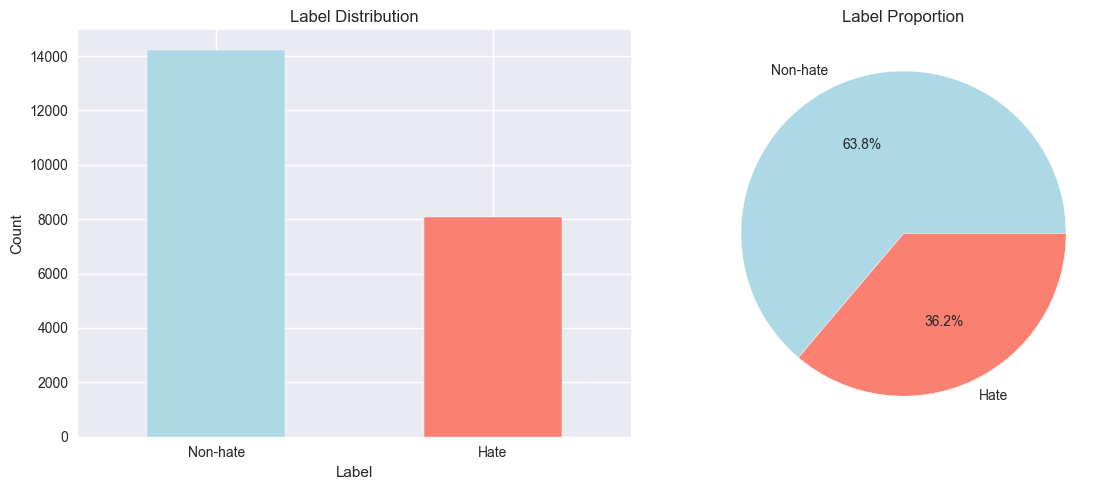

In [5]:
label_counts = df['label'].value_counts()
label_props = df['label'].value_counts(normalize=True)

print("Label Distribution:")
print(f"Non-hate (0): {label_counts[0]} ({label_props[0]:.2%})")
print(f"Hate (1): {label_counts[1]} ({label_props[1]:.2%})")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
label_counts.plot(kind='bar', ax=axes[0], color=['lightblue', 'salmon'])
axes[0].set_title('Label Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Non-hate', 'Hate'], rotation=0)

# Pie chart
axes[1].pie(label_counts.values, labels=['Non-hate', 'Hate'], autopct='%1.1f%%',
            colors=['lightblue', 'salmon'])
axes[1].set_title('Label Proportion')

plt.tight_layout()
plt.show()


Text Metrics by Label:
      word_count                  char_count                   sent_count  \
            mean median       std       mean median        std       mean   
label                                                                       
0      14.550372   14.0  7.768675  97.912042   94.0  53.418226   1.005410   
1      15.068128   13.0  9.196164  92.050539   81.0  55.763339   1.348693   

                       avg_word_len                      
      median       std         mean    median       std  
label                                                    
0        1.0  0.102859     5.782970  5.777778  0.919118  
1        1.0  0.824206     5.240946  5.263158  1.063489  


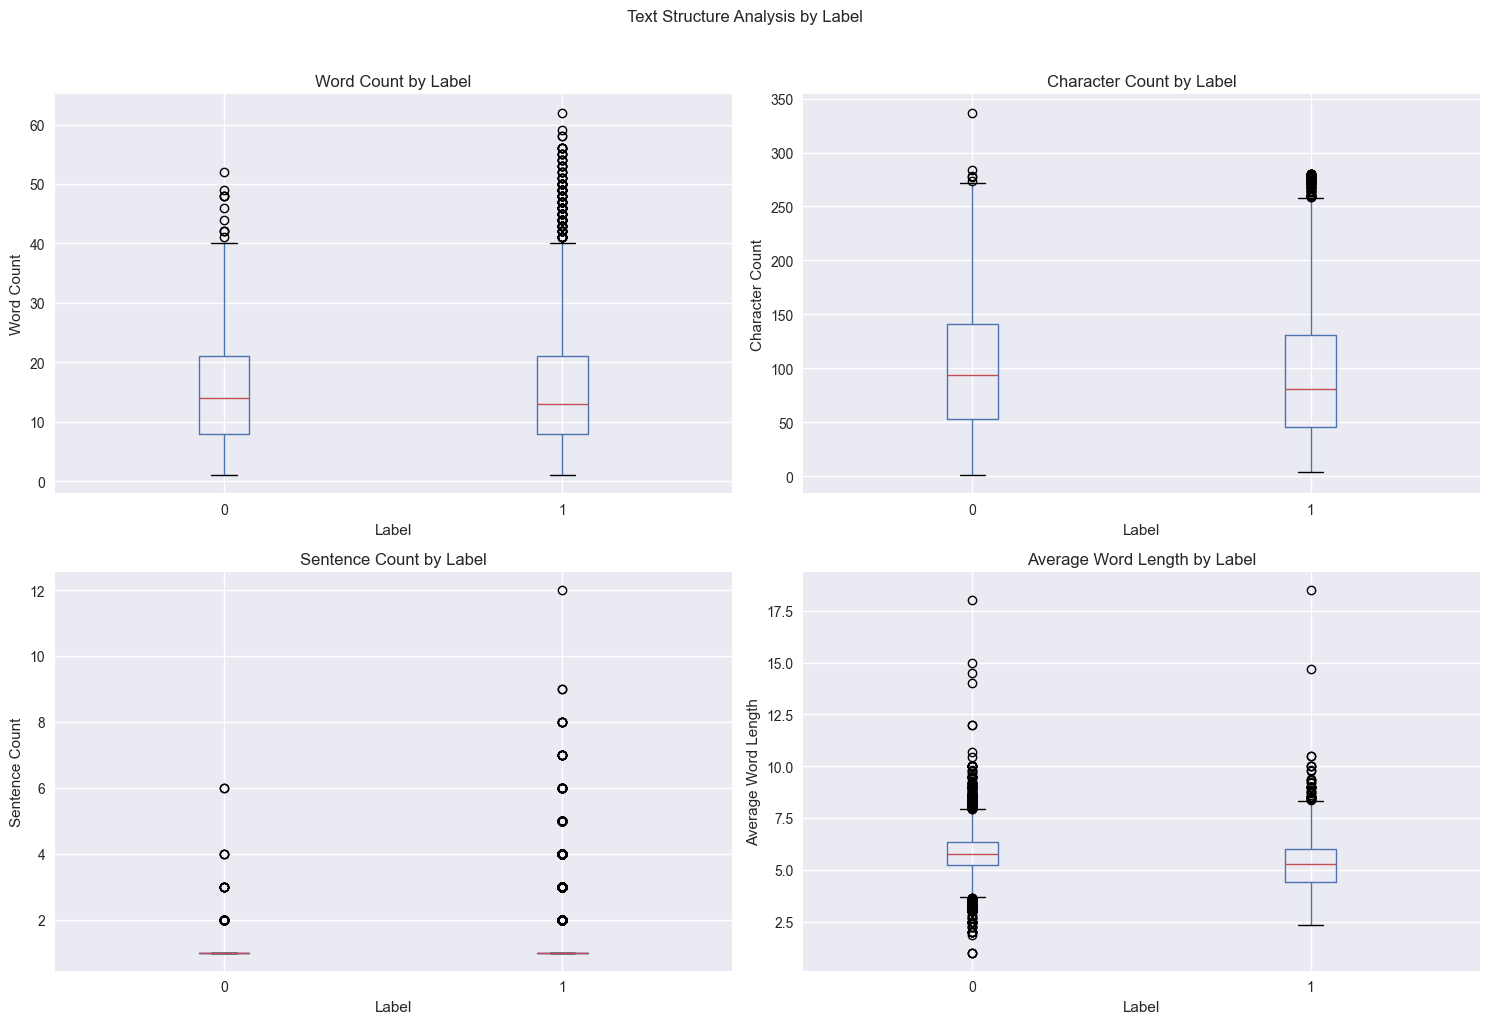

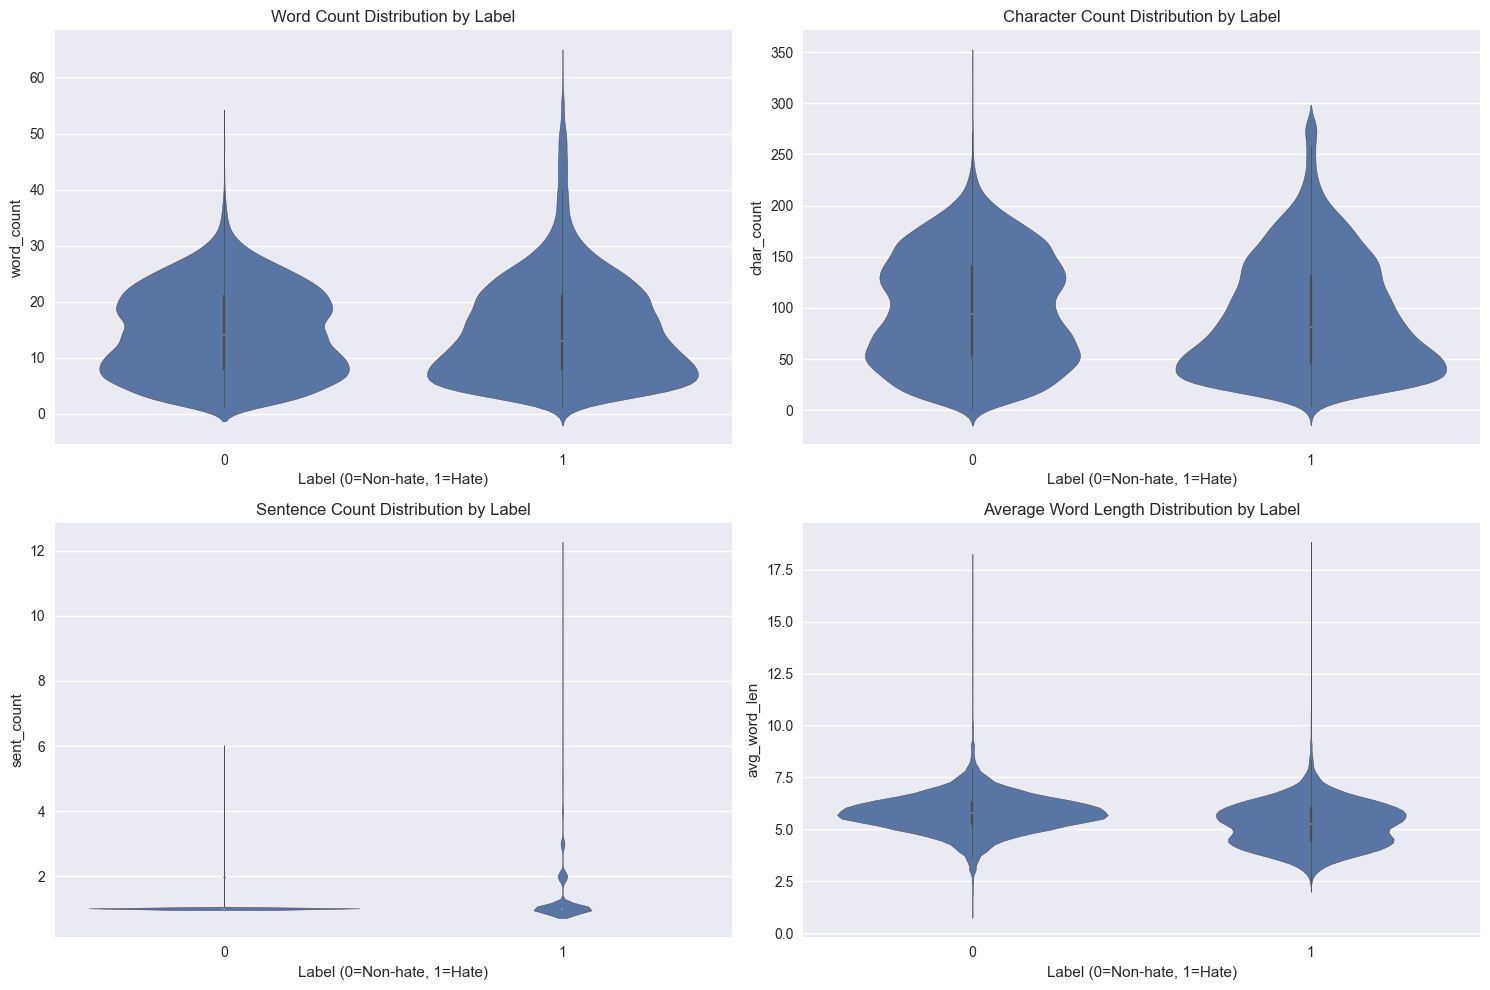

In [7]:
# 3. Text Length and Structure Distribution

def analyze_text_structure(text):
    """Analyze text structure metrics"""
    if pd.isna(text):
        return 0, 0, 0, 0

    text = str(text)
    char_count = len(text)
    words = text.split()
    word_count = len(words)

    # Sentence count using NLTK
    try:
        sentences = nltk.sent_tokenize(text)
        sent_count = len(sentences)
    except:
        sent_count = text.count('.') + text.count('!') + text.count('?') + 1

    # Average word length
    avg_word_len = np.mean([len(word) for word in words]) if words else 0

    return word_count, char_count, sent_count, avg_word_len


# Apply analysis
text_metrics = df['text'].apply(analyze_text_structure)
df['word_count'] = [x[0] for x in text_metrics]
df['char_count'] = [x[1] for x in text_metrics]
df['sent_count'] = [x[2] for x in text_metrics]
df['avg_word_len'] = [x[3] for x in text_metrics]

# Group by label
metrics_by_label = df.groupby('label')[
    ['word_count', 'char_count', 'sent_count', 'avg_word_len']].agg(['mean', 'median', 'std'])

print("Text Metrics by Label:")
print(metrics_by_label)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['word_count', 'char_count', 'sent_count', 'avg_word_len']
titles = ['Word Count', 'Character Count',
          'Sentence Count', 'Average Word Length']

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i % 2]

    # Box plot
    df.boxplot(column=metric, by='label', ax=ax)
    ax.set_title(f'{title} by Label')
    ax.set_xlabel('Label')
    ax.set_ylabel(title)

plt.suptitle('Text Structure Analysis by Label', y=1.02)
plt.tight_layout()
plt.show()

# Violin plots for better distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[i//2, i % 2]
    sns.violinplot(data=df, x='label', y=metric, ax=ax)
    ax.set_title(f'{title} Distribution by Label')
    ax.set_xlabel('Label (0=Non-hate, 1=Hate)')

plt.tight_layout()
plt.show()

Missing Values:
text            0
label           0
word_count      0
char_count      0
sent_count      0
avg_word_len    0
dtype: int64
Data Quality Summary:
            Quality Issue  Count  Percentage
0              Empty Text      0    0.000000
1  Short Text (<10 chars)    233    1.044515
2      Emoji Heavy (>20%)    102    0.457256
3         Contains Emojis    913    4.092886

Data Quality Issues by Label (%):
       is_empty  is_short  is_emoji_heavy
label                                    
0           0.0  1.503442        0.007025
1           0.0  0.235352        1.251084
Data Quality Summary:
            Quality Issue  Count  Percentage
0              Empty Text      0    0.000000
1  Short Text (<10 chars)    233    1.044515
2      Emoji Heavy (>20%)    102    0.457256
3         Contains Emojis    913    4.092886

Data Quality Issues by Label (%):
       is_empty  is_short  is_emoji_heavy
label                                    
0           0.0  1.503442        0.007025
1    

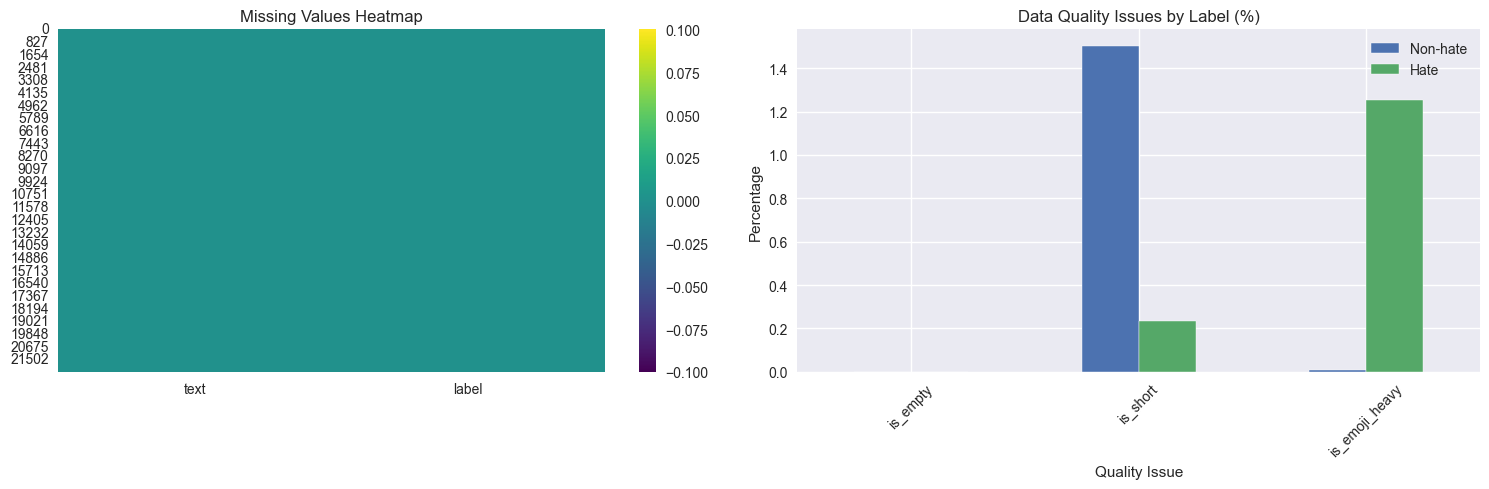

In [8]:
# 4. Missing Values and Data Quality Check

print("Missing Values:")
print(df.isnull().sum())

# Data quality flags


def check_data_quality(text):
    """Check various data quality metrics"""
    if pd.isna(text):
        return True, False, False, 0

    text = str(text)

    # Short text (less than 10 characters)
    is_short = len(text) < 10

    # Empty or whitespace only
    is_empty = len(text.strip()) == 0

    # Emoji heavy (more than 20% emojis)
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF\U00002702-\U000027B0\U000024C2-\U0001F251]+")
    emoji_count = len(emoji_pattern.findall(text))
    is_emoji_heavy = emoji_count / \
        len(text.split()) > 0.2 if text.split() else False

    return is_empty, is_short, is_emoji_heavy, emoji_count


quality_checks = df['text'].apply(check_data_quality)
df['is_empty'] = [x[0] for x in quality_checks]
df['is_short'] = [x[1] for x in quality_checks]
df['is_emoji_heavy'] = [x[2] for x in quality_checks]
df['emoji_count'] = [x[3] for x in quality_checks]

# Quality summary
quality_summary = pd.DataFrame({
    'Quality Issue': ['Empty Text', 'Short Text (<10 chars)', 'Emoji Heavy (>20%)', 'Contains Emojis'],
    'Count': [df['is_empty'].sum(), df['is_short'].sum(), df['is_emoji_heavy'].sum(), (df['emoji_count'] > 0).sum()],
    'Percentage': [df['is_empty'].mean()*100, df['is_short'].mean()*100,
                   df['is_emoji_heavy'].mean()*100, (df['emoji_count'] > 0).mean()*100]
})

print("Data Quality Summary:")
print(quality_summary)

# Quality by label
quality_by_label = df.groupby(
    'label')[['is_empty', 'is_short', 'is_emoji_heavy']].mean() * 100

print("\nData Quality Issues by Label (%):")
print(quality_by_label)

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Missing values heatmap
sns.heatmap(df[['text', 'label']].isnull(), cmap='viridis', ax=axes[0])
axes[0].set_title('Missing Values Heatmap')

# Quality issues by label
quality_by_label.T.plot(kind='bar', ax=axes[1])
axes[1].set_title('Data Quality Issues by Label (%)')
axes[1].set_xlabel('Quality Issue')
axes[1].set_ylabel('Percentage')
axes[1].legend(['Non-hate', 'Hate'])
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Total tokens: 324173
Unique tokens (vocabulary size): 30699
Type-Token Ratio (TTR): 0.0947

Top 20 words in HATE texts:
nigeria: 2177
zoo: 1702
christians: 1371
kill: 1300
you: 1195
the: 1024
people: 840
to: 781
called: 749
wo: 682
no: 611
and: 606
like: 594
go: 574
na: 531
is: 485
this: 479
almajiri: 470
buhari: 446
country: 416

Top 20 words in NON-HATE texts:
almajiri: 3568
nigeria: 2588
christians: 2354
ipob: 2061
people: 1859
dead: 1685
kill: 1504
arne: 1366
amp: 1157
like: 1134
buhari: 1112
one: 1084
stupid: 1084
fake: 953
us: 842
god: 841
state: 751
know: 739
president: 714
biafra: 651

Top 20 words in HATE texts:
nigeria: 2177
zoo: 1702
christians: 1371
kill: 1300
you: 1195
the: 1024
people: 840
to: 781
called: 749
wo: 682
no: 611
and: 606
like: 594
go: 574
na: 531
is: 485
this: 479
almajiri: 470
buhari: 446
country: 416

Top 20 words in NON-HATE texts:
almajiri: 3568
nigeria: 2588
christians: 2354
ipob: 2061
people: 1859
dead: 1685
kill: 1504
arne: 1366
amp: 1157
like: 1134
bu

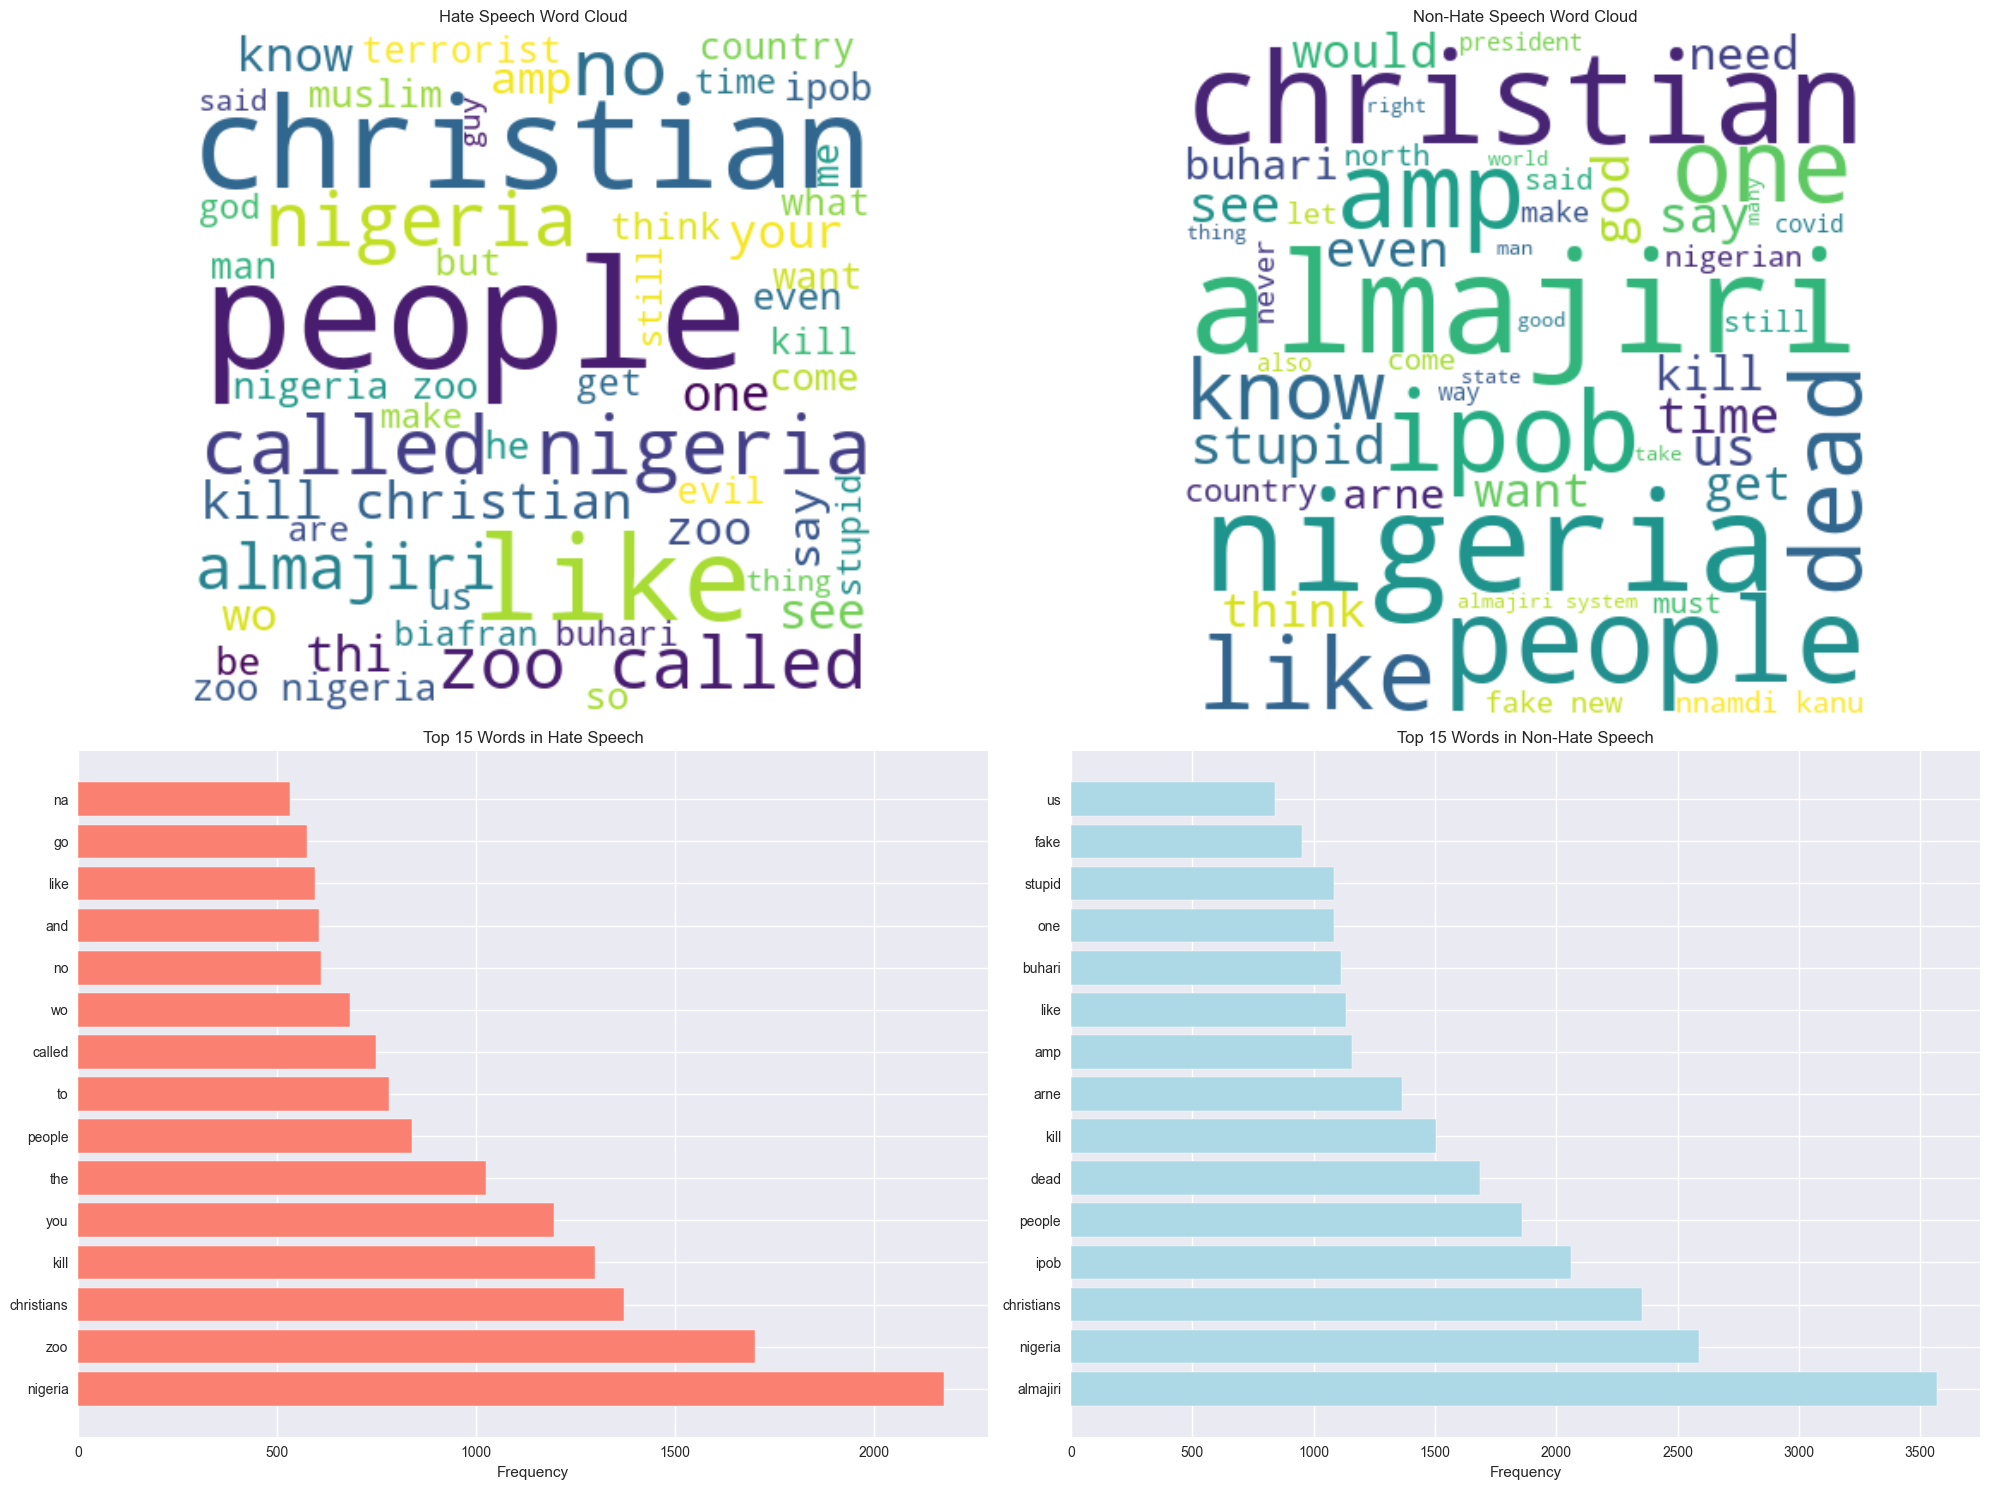


Type-Token Ratio by Label:
Non-hate: 0.1145
Hate: 0.1342


In [9]:
# 5. Vocabulary and Word Frequency Analysis

def basic_tokenize(text):
    """Basic tokenization preserving Pidgin slang"""
    if pd.isna(text):
        return []

    text = str(text).lower()
    # Remove punctuation but preserve contractions and Pidgin patterns
    text = re.sub(r'[^\w\s\']', ' ', text)
    tokens = text.split()
    return [token for token in tokens if len(token) > 1]


def get_pidgin_variations(tokens):
    """Flag common Pidgin variations"""
    pidgin_patterns = {
        'dey_variants': ['dey', 'de', 'day'],
        'wetin_variants': ['wetin', 'wettin', 'what'],
        'common_pidgin': ['chale', 'wahala', 'abeg', 'abi', 'na', 'go', 'fit', 'pikin']
    }

    found_patterns = {}
    for pattern_name, variants in pidgin_patterns.items():
        found_patterns[pattern_name] = sum(
            1 for token in tokens if token in variants)

    return found_patterns


# Tokenize all texts
df['tokens'] = df['text'].apply(basic_tokenize)
df['token_count'] = df['tokens'].apply(len)

# Get vocabulary statistics
all_tokens = [token for tokens in df['tokens'] for token in tokens]
unique_tokens = set(all_tokens)
vocab_size = len(unique_tokens)

print(f"Total tokens: {len(all_tokens)}")
print(f"Unique tokens (vocabulary size): {vocab_size}")
print(f"Type-Token Ratio (TTR): {vocab_size/len(all_tokens):.4f}")

# Top words by class
hate_tokens = [token for idx, tokens in enumerate(
    df['tokens']) if df.iloc[idx]['label'] == 1 for token in tokens]
nonhate_tokens = [token for idx, tokens in enumerate(
    df['tokens']) if df.iloc[idx]['label'] == 0 for token in tokens]

hate_counter = Counter(hate_tokens)
nonhate_counter = Counter(nonhate_tokens)

print("\nTop 20 words in HATE texts:")
for word, count in hate_counter.most_common(20):
    print(f"{word}: {count}")

print("\nTop 20 words in NON-HATE texts:")
for word, count in nonhate_counter.most_common(20):
    print(f"{word}: {count}")

# Pidgin pattern analysis
pidgin_patterns = df['tokens'].apply(get_pidgin_variations)
pidgin_df = pd.DataFrame(list(pidgin_patterns))
pidgin_summary = pidgin_df.groupby(df['label']).mean()

print("\nPidgin Pattern Usage by Label:")
print(pidgin_summary)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# Word clouds
pidgin_stopwords = {'dey', 'na', 'abi', 'go', 'fit', 'for',
                    'the', 'and', 'to', 'of', 'in', 'is', 'you', 'that', 'it'}

# Hate word cloud
hate_text = ' '.join(hate_tokens)
hate_wordcloud = WordCloud(width=400, height=400, background_color='white',
                           stopwords=pidgin_stopwords, max_words=50).generate(hate_text)
axes[0, 0].imshow(hate_wordcloud, interpolation='bilinear')
axes[0, 0].set_title('Hate Speech Word Cloud')
axes[0, 0].axis('off')

# Non-hate word cloud
nonhate_text = ' '.join(nonhate_tokens)
nonhate_wordcloud = WordCloud(width=400, height=400, background_color='white',
                              stopwords=pidgin_stopwords, max_words=50).generate(nonhate_text)
axes[0, 1].imshow(nonhate_wordcloud, interpolation='bilinear')
axes[0, 1].set_title('Non-Hate Speech Word Cloud')
axes[0, 1].axis('off')

# Top words comparison
top_hate = dict(hate_counter.most_common(15))
top_nonhate = dict(nonhate_counter.most_common(15))

axes[1, 0].barh(list(top_hate.keys()), list(top_hate.values()), color='salmon')
axes[1, 0].set_title('Top 15 Words in Hate Speech')
axes[1, 0].set_xlabel('Frequency')

axes[1, 1].barh(list(top_nonhate.keys()), list(
    top_nonhate.values()), color='lightblue')
axes[1, 1].set_title('Top 15 Words in Non-Hate Speech')
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# Type-Token Ratio by class
ttr_by_label = df.groupby('label').apply(lambda x: len(set([token for tokens in x['tokens'] for token in tokens])) /
                                         len([token for tokens in x['tokens'] for token in tokens]))
print(f"\nType-Token Ratio by Label:")
print(f"Non-hate: {ttr_by_label[0]:.4f}")
print(f"Hate: {ttr_by_label[1]:.4f}")


=== 1-GRAMS ===

Top 10 1-grams in HATE:
'nigeria': 2177
'zoo': 1702
'christians': 1371
'kill': 1300
'you': 1195
'the': 1024
'people': 840
'to': 781
'called': 749
'wo': 682

Top 10 1-grams in NON-HATE:
'almajiri': 3568
'nigeria': 2588
'christians': 2354
'ipob': 2061
'people': 1859
'dead': 1685
'kill': 1504
'arne': 1366
'amp': 1157
'like': 1134

=== 2-GRAMS ===

Top 10 2-grams in HATE:
'called nigeria': 518
'zoo called': 425
'kill christians': 384
'zoo nigeria': 287
'nigeria zoo': 284
'nnamdi kanu': 163
'nny3 f3': 100
'mazi nnamdi': 96
'zoo country': 86
'boko haram': 80

Top 10 2-grams in NON-HATE:
'fake news': 404
'nnamdi kanu': 386
'almajiri system': 353
'kill christians': 227
'arne sorenson': 218
'almajiri schools': 201
'mazi nnamdi': 173
'almajiri children': 139
'ceo arne': 126
'ipob members': 126

=== 3-GRAMS ===

Top 10 3-grams in HATE:
'zoo called nigeria': 388
'mazi nnamdi kanu': 91
'trying kill christians': 50
'country called nigeria': 43
'abortion sex marriage': 43
'support a

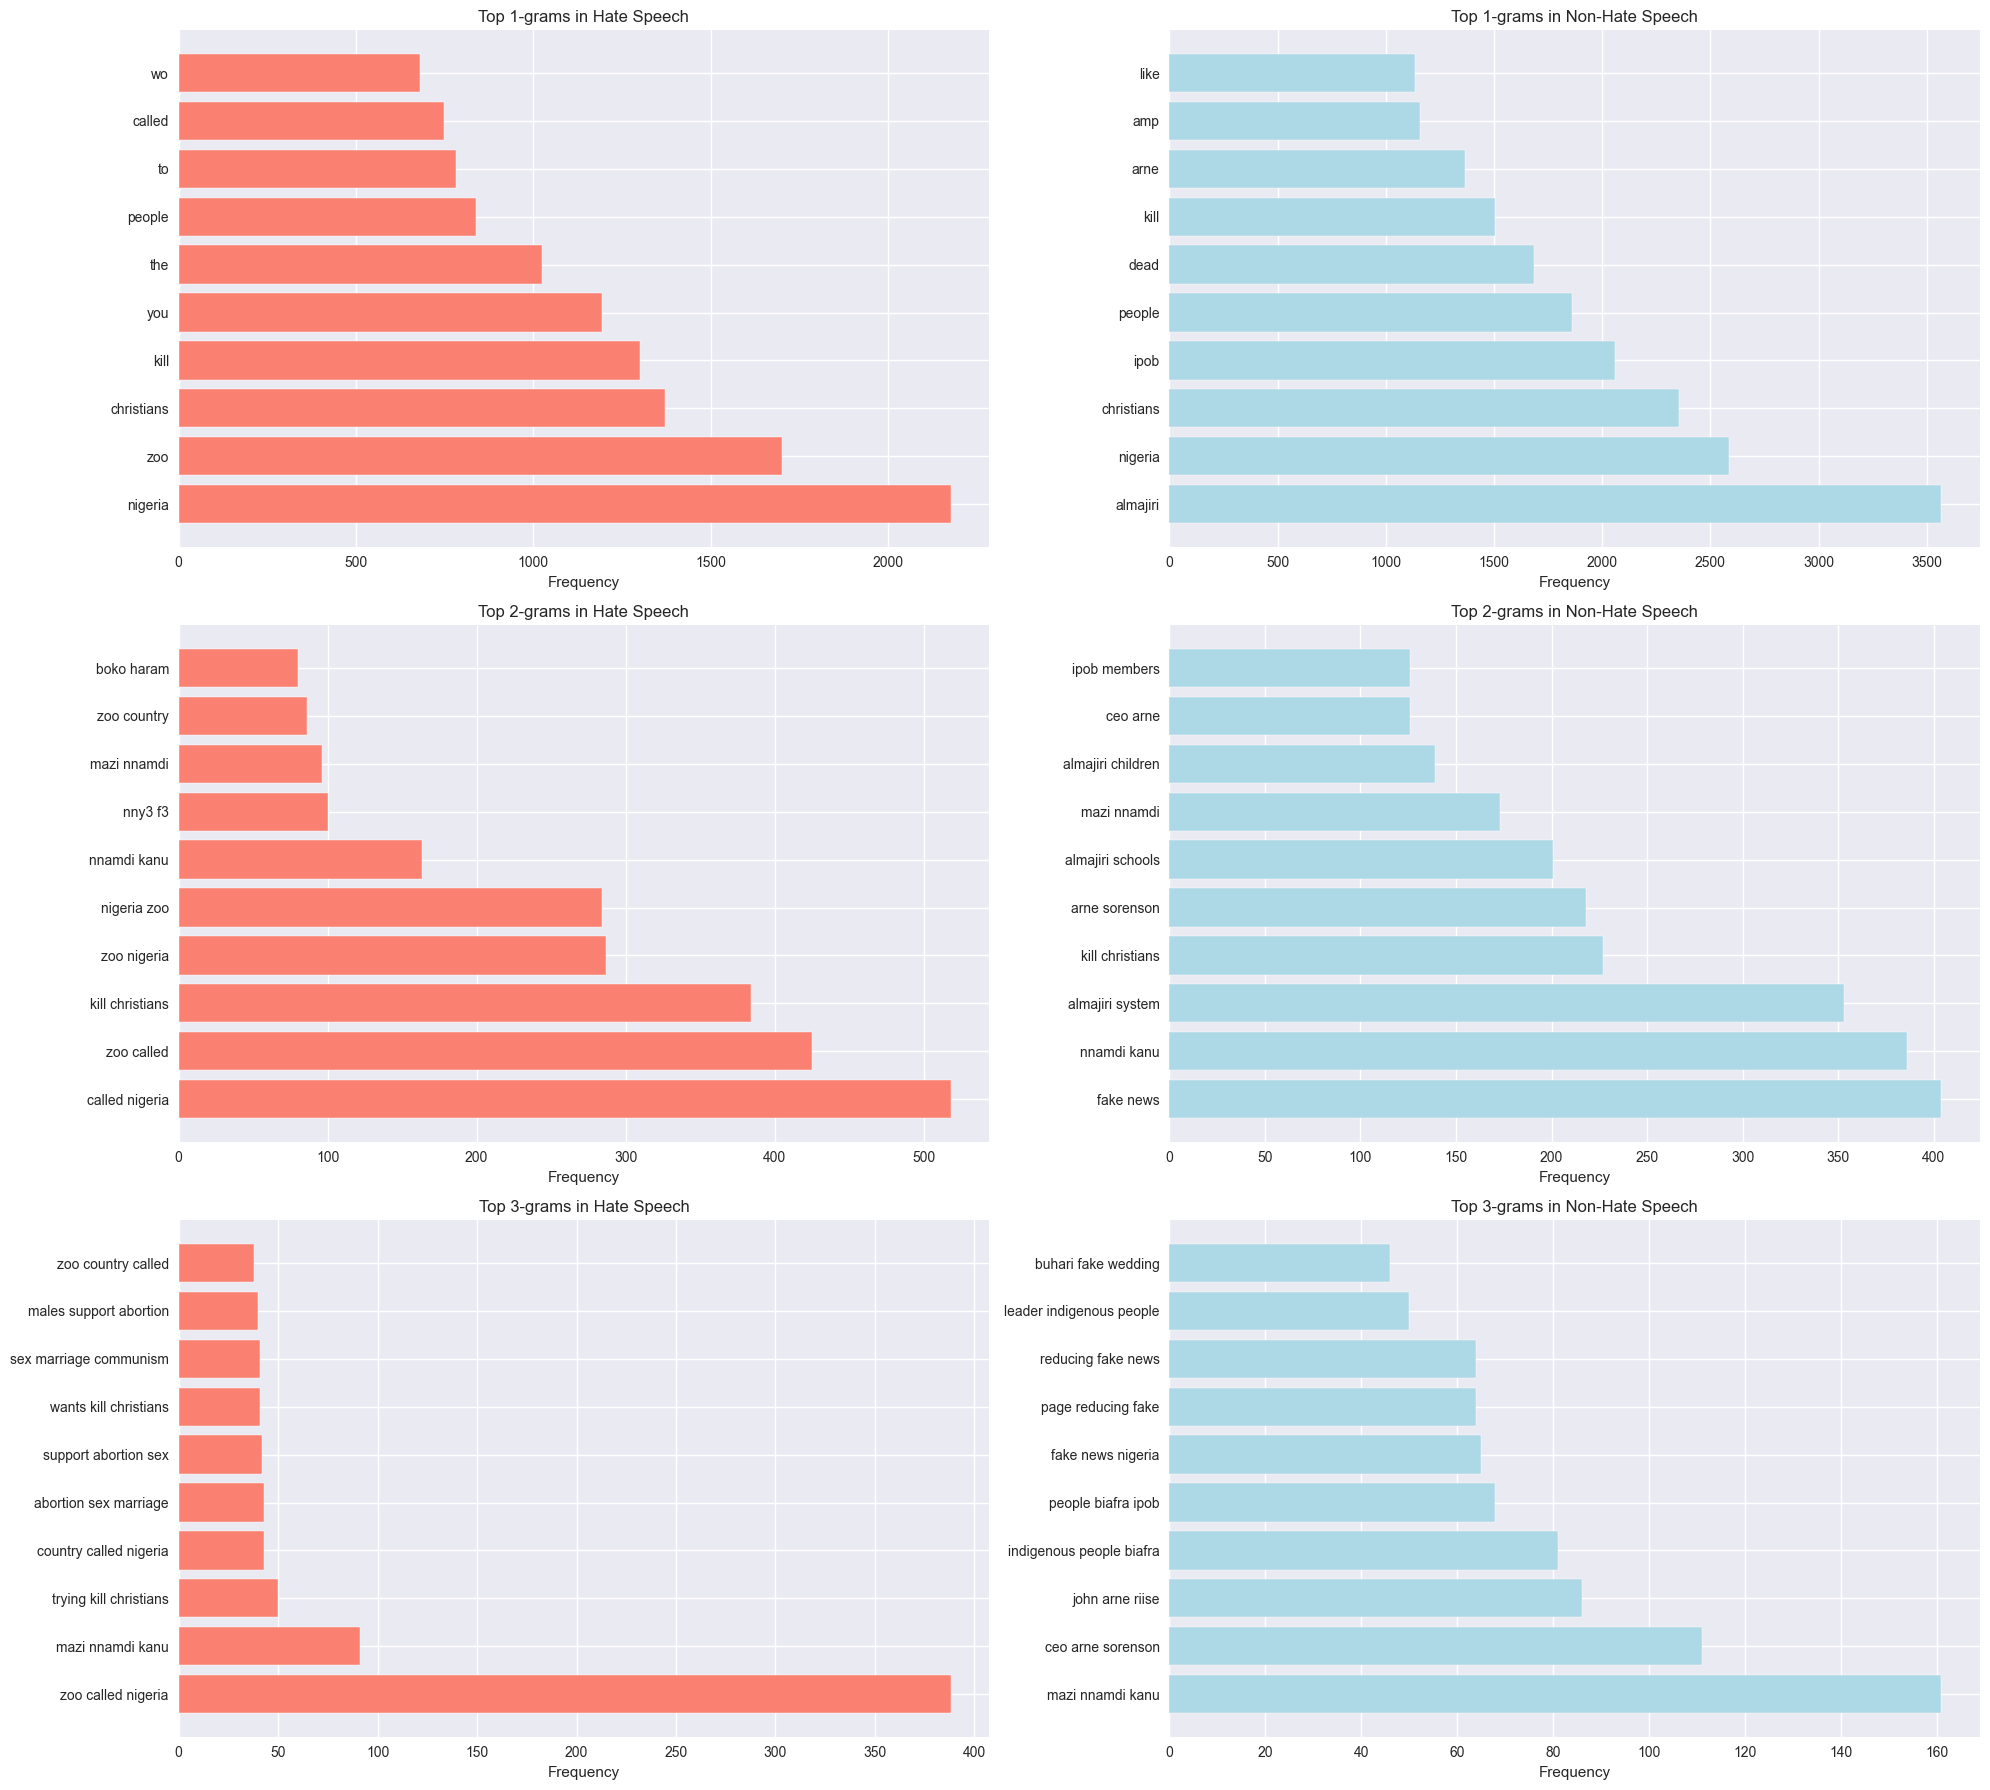

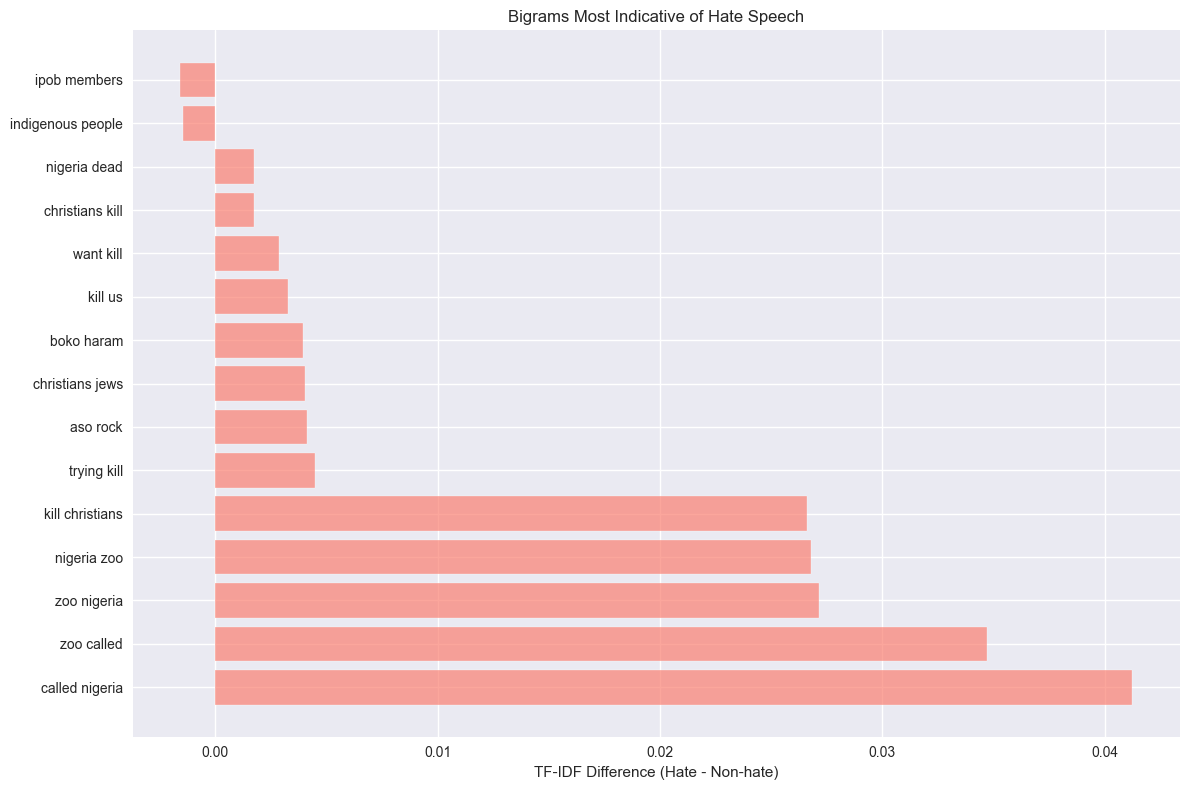

In [11]:
# 6. N-gram Analysis

def get_ngrams(tokens, n):
    """Extract n-grams from tokens"""
    return list(ngrams(tokens, n))


def get_ngram_freq(texts, n, top_k=10):
    """Get top-k n-grams from texts"""
    all_ngrams = []
    for tokens in texts:
        ngrams_list = get_ngrams(tokens, n)
        all_ngrams.extend([' '.join(gram) for gram in ngrams_list])

    return Counter(all_ngrams).most_common(top_k)


# Separate texts by label
hate_texts = df[df['label'] == 1]['tokens'].tolist()
nonhate_texts = df[df['label'] == 0]['tokens'].tolist()

# N-gram analysis for each class
ngram_results = {}

for n in [1, 2, 3]:
    ngram_results[f'{n}gram'] = {
        'hate': get_ngram_freq(hate_texts, n, 10),
        'nonhate': get_ngram_freq(nonhate_texts, n, 10)
    }

# Print results
for n in [1, 2, 3]:
    print(f"\n=== {n}-GRAMS ===")
    print(f"\nTop 10 {n}-grams in HATE:")
    for gram, count in ngram_results[f'{n}gram']['hate']:
        print(f"'{gram}': {count}")

    print(f"\nTop 10 {n}-grams in NON-HATE:")
    for gram, count in ngram_results[f'{n}gram']['nonhate']:
        print(f"'{gram}': {count}")

# TF-IDF analysis for bigrams


def tfidf_ngrams(df, n=2, max_features=20):
    """TF-IDF analysis for n-grams"""
    # Prepare texts
    texts = df['text'].fillna('').astype(str).tolist()
    labels = df['label'].tolist()

    # Vectorize
    vectorizer = TfidfVectorizer(ngram_range=(n, n), max_features=max_features,
                                 stop_words=None, lowercase=True)

    try:
        X = vectorizer.fit_transform(texts)
        feature_names = vectorizer.get_feature_names_out()

        # Get TF-IDF scores by class
        hate_mask = np.array(labels) == 1
        nonhate_mask = np.array(labels) == 0

        hate_scores = X[hate_mask].mean(axis=0).A1
        nonhate_scores = X[nonhate_mask].mean(axis=0).A1

        # Create results dataframe
        tfidf_results = pd.DataFrame({
            'ngram': feature_names,
            'hate_score': hate_scores,
            'nonhate_score': nonhate_scores,
            'difference': hate_scores - nonhate_scores
        })

        return tfidf_results.sort_values('difference', ascending=False)

    except Exception as e:
        print(f"TF-IDF analysis failed: {e}")
        return pd.DataFrame()


# TF-IDF bigram analysis
tfidf_bigrams = tfidf_ngrams(df, n=2, max_features=30)

if not tfidf_bigrams.empty:
    print("\n=== TF-IDF BIGRAM ANALYSIS ===")
    print("\nTop bigrams favoring HATE:")
    print(tfidf_bigrams.head(10)[['ngram', 'difference']])

    print("\nTop bigrams favoring NON-HATE:")
    print(tfidf_bigrams.tail(10)[['ngram', 'difference']])

# Visualizations
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

# Plot n-grams for each class
for i, n in enumerate([1, 2, 3]):
    # Hate n-grams
    hate_grams = ngram_results[f'{n}gram']['hate']
    if hate_grams:
        grams, counts = zip(*hate_grams)
        axes[i, 0].barh(range(len(grams)), counts, color='salmon')
        axes[i, 0].set_yticks(range(len(grams)))
        axes[i, 0].set_yticklabels(grams)
        axes[i, 0].set_title(f'Top {n}-grams in Hate Speech')
        axes[i, 0].set_xlabel('Frequency')

    # Non-hate n-grams
    nonhate_grams = ngram_results[f'{n}gram']['nonhate']
    if nonhate_grams:
        grams, counts = zip(*nonhate_grams)
        axes[i, 1].barh(range(len(grams)), counts, color='lightblue')
        axes[i, 1].set_yticks(range(len(grams)))
        axes[i, 1].set_yticklabels(grams)
        axes[i, 1].set_title(f'Top {n}-grams in Non-Hate Speech')
        axes[i, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

# TF-IDF visualization
if not tfidf_bigrams.empty:
    plt.figure(figsize=(12, 8))

    # Top hate-indicating bigrams
    top_hate = tfidf_bigrams.head(15)
    plt.barh(range(len(top_hate)),
             top_hate['difference'], color='salmon', alpha=0.7)
    plt.yticks(range(len(top_hate)), top_hate['ngram'])
    plt.xlabel('TF-IDF Difference (Hate - Non-hate)')
    plt.title('Bigrams Most Indicative of Hate Speech')
    plt.tight_layout()
    plt.show()

Sentiment Analysis Results:
      polarity                  subjectivity                 
          mean median       std         mean median       std
label                                                        
0     -0.01716    0.0  0.295864     0.396987    0.4  0.320943
1     -0.00925    0.0  0.272995     0.300530    0.2  0.327106

Average Sentiment by Label:
       polarity  subjectivity
label                        
0      -0.01716      0.396987
1      -0.00925      0.300530

Correlation with hate label:
Polarity: 0.0132
Subjectivity: -0.1420


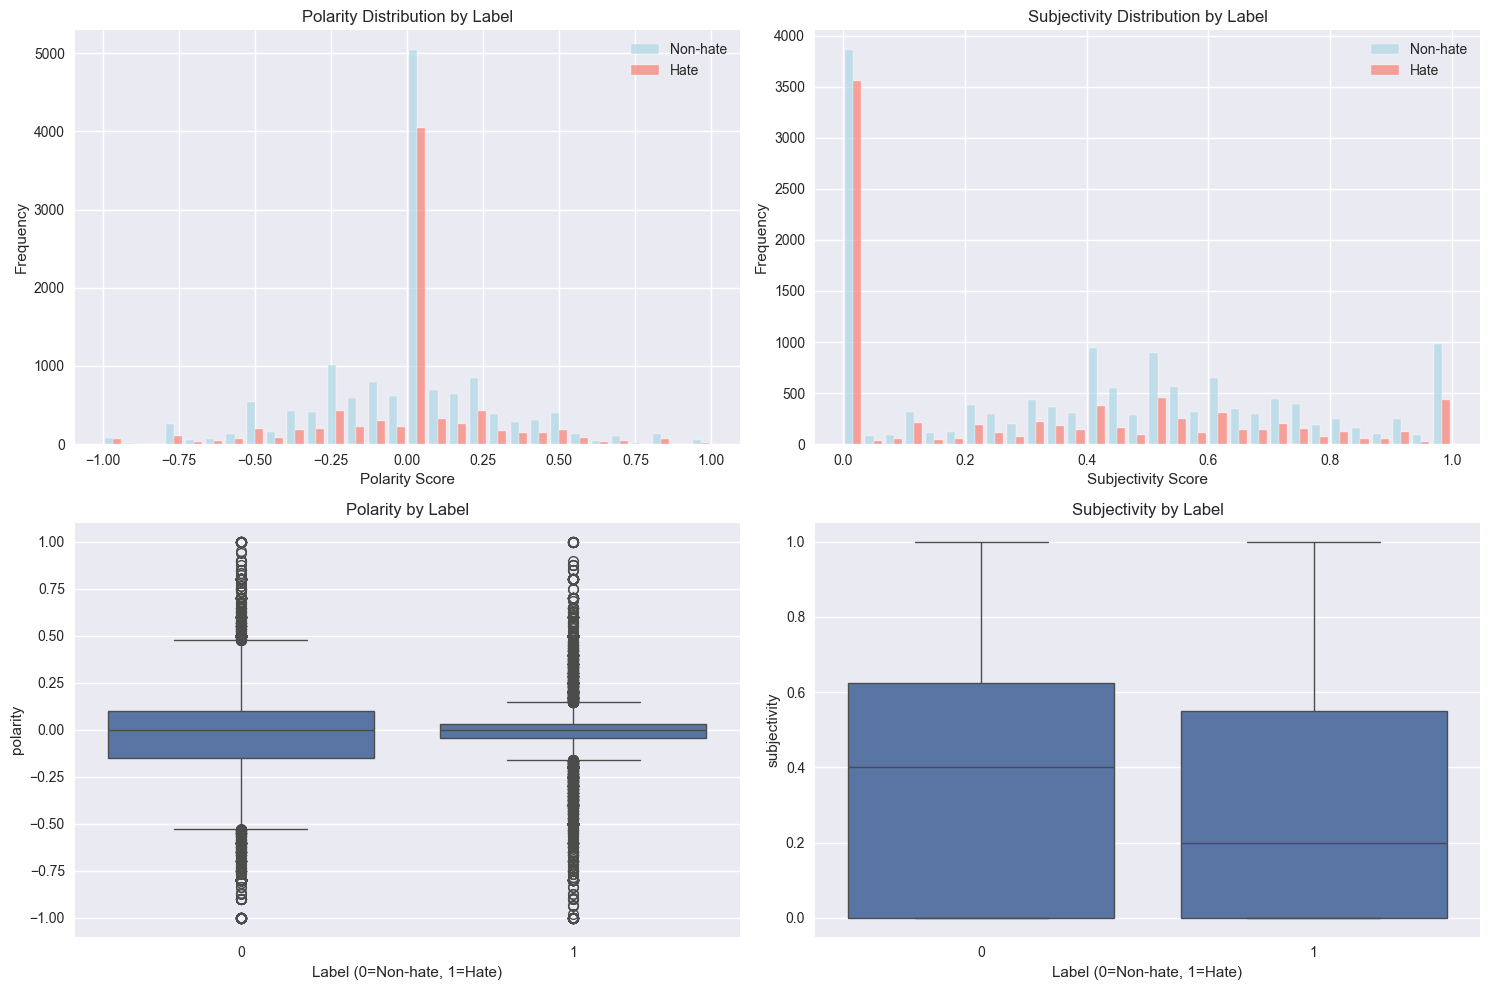

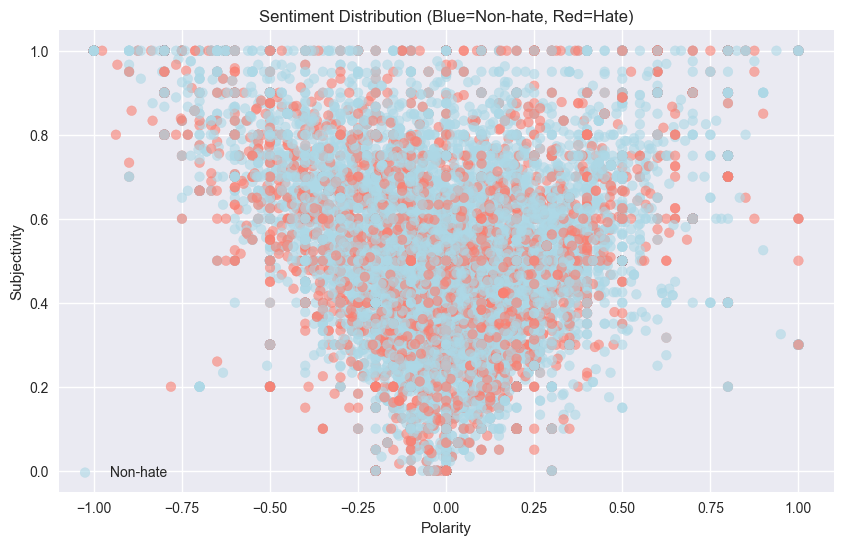

In [12]:
# 7. Sentiment and Polarity Analysis

def analyze_sentiment(text):
    """Analyze sentiment using TextBlob"""
    if pd.isna(text):
        return 0, 0

    try:
        blob = TextBlob(str(text))
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    except:
        return 0, 0


# Apply sentiment analysis
sentiment_scores = df['text'].apply(analyze_sentiment)
df['polarity'] = [x[0] for x in sentiment_scores]
df['subjectivity'] = [x[1] for x in sentiment_scores]

# Sentiment statistics by label
sentiment_stats = df.groupby('label')[['polarity', 'subjectivity']].agg([
    'mean', 'median', 'std'])

print("Sentiment Analysis Results:")
print(sentiment_stats)

# Sentiment distribution
sentiment_by_label = df.groupby('label')[['polarity', 'subjectivity']].mean()
print(f"\nAverage Sentiment by Label:")
print(sentiment_by_label)

# Correlation with label
polarity_corr = df['polarity'].corr(df['label'])
subjectivity_corr = df['subjectivity'].corr(df['label'])

print(f"\nCorrelation with hate label:")
print(f"Polarity: {polarity_corr:.4f}")
print(f"Subjectivity: {subjectivity_corr:.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Polarity distribution
axes[0, 0].hist([df[df['label'] == 0]['polarity'], df[df['label'] == 1]['polarity']],
                bins=30, alpha=0.7, label=['Non-hate', 'Hate'], color=['lightblue', 'salmon'])
axes[0, 0].set_title('Polarity Distribution by Label')
axes[0, 0].set_xlabel('Polarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Subjectivity distribution
axes[0, 1].hist([df[df['label'] == 0]['subjectivity'], df[df['label'] == 1]['subjectivity']],
                bins=30, alpha=0.7, label=['Non-hate', 'Hate'], color=['lightblue', 'salmon'])
axes[0, 1].set_title('Subjectivity Distribution by Label')
axes[0, 1].set_xlabel('Subjectivity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Box plots
sns.boxplot(data=df, x='label', y='polarity', ax=axes[1, 0])
axes[1, 0].set_title('Polarity by Label')
axes[1, 0].set_xlabel('Label (0=Non-hate, 1=Hate)')

sns.boxplot(data=df, x='label', y='subjectivity', ax=axes[1, 1])
axes[1, 1].set_title('Subjectivity by Label')
axes[1, 1].set_xlabel('Label (0=Non-hate, 1=Hate)')

plt.tight_layout()
plt.show()

# Scatter plot of polarity vs subjectivity
plt.figure(figsize=(10, 6))
colors = ['lightblue' if x == 0 else 'salmon' for x in df['label']]
plt.scatter(df['polarity'], df['subjectivity'], c=colors, alpha=0.6)
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.title('Sentiment Distribution (Blue=Non-hate, Red=Hate)')
plt.legend(['Non-hate', 'Hate'])
plt.show()

Detecting languages...
Analyzing code-mixing patterns...
Analyzing code-mixing patterns...
Language Distribution:
detected_lang
en         17711
so           520
sw           400
af           361
et           350
it           346
nl           335
tl           266
id           217
ca           204
da           189
cy           185
no           158
fr           144
ro           139
fi           126
sl           107
sv           104
es           100
pl            85
hr            54
tr            41
pt            40
de            29
sk            26
lt            17
sq            16
hu            15
lv             8
unknown        6
cs             4
vi             4
Name: count, dtype: int64

Code-mixing Patterns by Label:
       english_ratio  pidgin_ratio  local_ratio  code_mixing_score
label                                                             
0           0.004747      0.006713     0.000516           0.011975
1           0.046117      0.017639     0.014575           0.078331

C

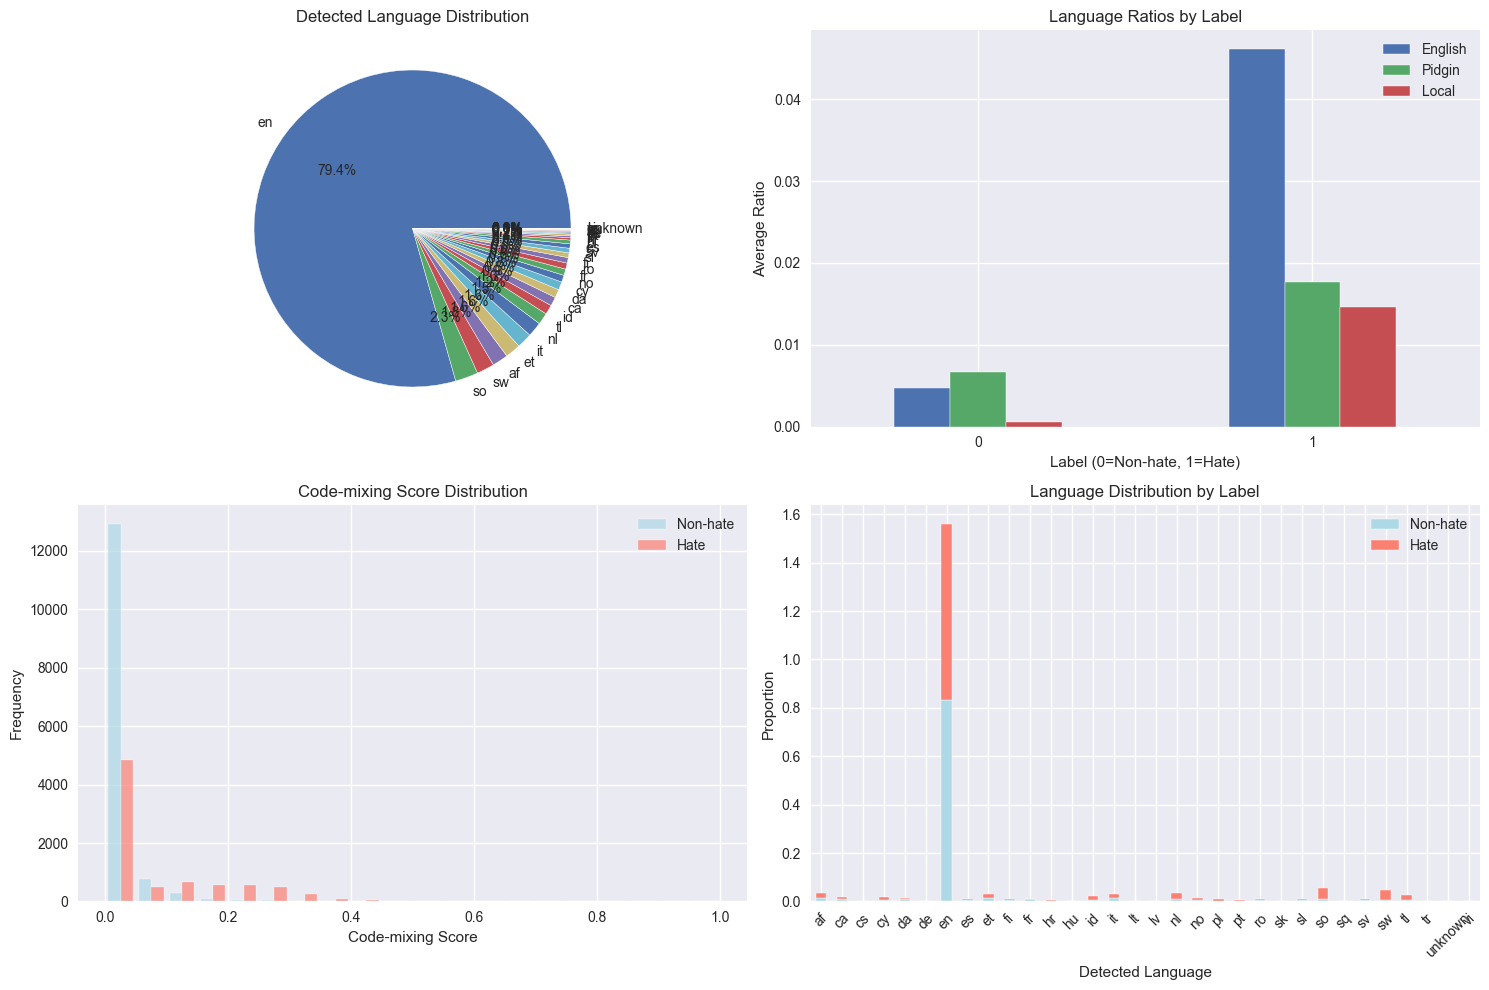

In [16]:
# 8. Language Detection and Code-Mixing Analysis

def detect_language(text):
    """Detect language with error handling"""
    if pd.isna(text) or len(str(text).strip()) < 3:
        return 'unknown'

    try:
        return detect(str(text))
    except LangDetectException:
        return 'unknown'


def analyze_code_mixing(text):
    """Analyze code-mixing patterns"""
    if pd.isna(text):
        return 0, 0, 0

    text = str(text).lower()
    words = text.split()

    if not words:
        return 0, 0, 0

    # Common English stopwords
    english_words = {'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
                     'this', 'that', 'these', 'those', 'is', 'are', 'was', 'were', 'be', 'been',
                     'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should'}

    # Common Pidgin words
    pidgin_words = {'dey', 'de', 'na', 'abi', 'wetin', 'chale', 'wahala', 'abeg', 'fit', 'go',
                    'pikin', 'oya', 'make', 'wey', 'how', 'where', 'when', 'why', 'small', 'big'}

    # Common Twi/local words (basic set)
    local_words = {'wo', 'me', 'yɛ', 'no',
                   'obruni', 'kwasia', 'gyimii', 'adwo', 'awo'}

    english_count = sum(1 for word in words if word in english_words)
    pidgin_count = sum(1 for word in words if word in pidgin_words)
    local_count = sum(1 for word in words if word in local_words)

    total_words = len(words)
    english_ratio = english_count / total_words
    pidgin_ratio = pidgin_count / total_words
    local_ratio = local_count / total_words

    return english_ratio, pidgin_ratio, local_ratio


# Apply language detection
print("Detecting languages...")
df['detected_lang'] = df['text'].apply(detect_language)

# Apply code-mixing analysis
print("Analyzing code-mixing patterns...")
mixing_analysis = df['text'].apply(analyze_code_mixing)
df['english_ratio'] = [x[0] for x in mixing_analysis]
df['pidgin_ratio'] = [x[1] for x in mixing_analysis]
df['local_ratio'] = [x[2] for x in mixing_analysis]

# Calculate code-mixing score (higher = more mixed)
df['code_mixing_score'] = df['english_ratio'] + \
    df['pidgin_ratio'] + df['local_ratio']
df['is_code_mixed'] = df['code_mixing_score'] > 0.2

# Language distribution
lang_dist = df['detected_lang'].value_counts()
print("Language Distribution:")
print(lang_dist)

# Code-mixing by label
mixing_by_label = df.groupby('label')[
    ['english_ratio', 'pidgin_ratio', 'local_ratio', 'code_mixing_score']].mean()
print(f"\nCode-mixing Patterns by Label:")
print(mixing_by_label)

# Code-mixing frequency by label
code_mix_by_label = df.groupby(
    'label')['is_code_mixed'].value_counts(normalize=True)
print(f"\nCode-mixing Frequency by Label:")
print(code_mix_by_label)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Language distribution pie chart
lang_dist.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%')
axes[0, 0].set_title('Detected Language Distribution')
axes[0, 0].set_ylabel('')

# Code-mixing ratios by label
mixing_by_label[['english_ratio', 'pidgin_ratio', 'local_ratio']].plot(
    kind='bar', ax=axes[0, 1])
axes[0, 1].set_title('Language Ratios by Label')
axes[0, 1].set_xlabel('Label (0=Non-hate, 1=Hate)')
axes[0, 1].set_ylabel('Average Ratio')
axes[0, 1].legend(['English', 'Pidgin', 'Local'])
axes[0, 1].tick_params(axis='x', rotation=0)

# Code-mixing score distribution
axes[1, 0].hist([df[df['label'] == 0]['code_mixing_score'], df[df['label'] == 1]['code_mixing_score']],
                bins=20, alpha=0.7, label=['Non-hate', 'Hate'], color=['lightblue', 'salmon'])
axes[1, 0].set_title('Code-mixing Score Distribution')
axes[1, 0].set_xlabel('Code-mixing Score')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Language by label stacked bar
lang_label_crosstab = pd.crosstab(
    df['detected_lang'], df['label'], normalize='columns')
lang_label_crosstab.plot(kind='bar', stacked=True,
                         ax=axes[1, 1], color=['lightblue', 'salmon'])
axes[1, 1].set_title('Language Distribution by Label')
axes[1, 1].set_xlabel('Detected Language')
axes[1, 1].set_ylabel('Proportion')
axes[1, 1].legend(['Non-hate', 'Hate'])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Extracting named entities...
Flagging Pidgin targets...
Flagging Pidgin targets...
Entity Statistics by Label:
       person_count  location_count  org_count  target_count
label                                                       
0          0.239919        0.180202   0.162287      0.124772
1          0.436641        0.230026   0.238325      0.129320

Top persons mentioned in HATE texts:
zoo: 109
zoo nigeria: 96
kurasini: 42
jesus: 35
god: 34
nigeria zoo: 33
dey: 29
asantefo: 27
wabodam: 24
wo ho: 23

Top persons mentioned in NON-HATE texts:
john arne: 96
jesus: 88
god: 72
duncan: 41
muhammadu buhari: 39
jonathan: 37
donald trump: 25
nnamdi kanu: 25
mazi nnamdi: 24
arne sorenson: 23

Top target terms in HATE texts:
i: 1082
a: 894
s: 656
d: 513
w: 331
t: 315
k: 309
p: 265
m: 243
u: 241

Top target terms in NON-HATE texts:
d: 1606
i: 1401
t: 1225
s: 1164
p: 1143
u: 1072
a: 580
m: 400
o: 235
n: 93
Entity Statistics by Label:
       person_count  location_count  org_count  target_count
l

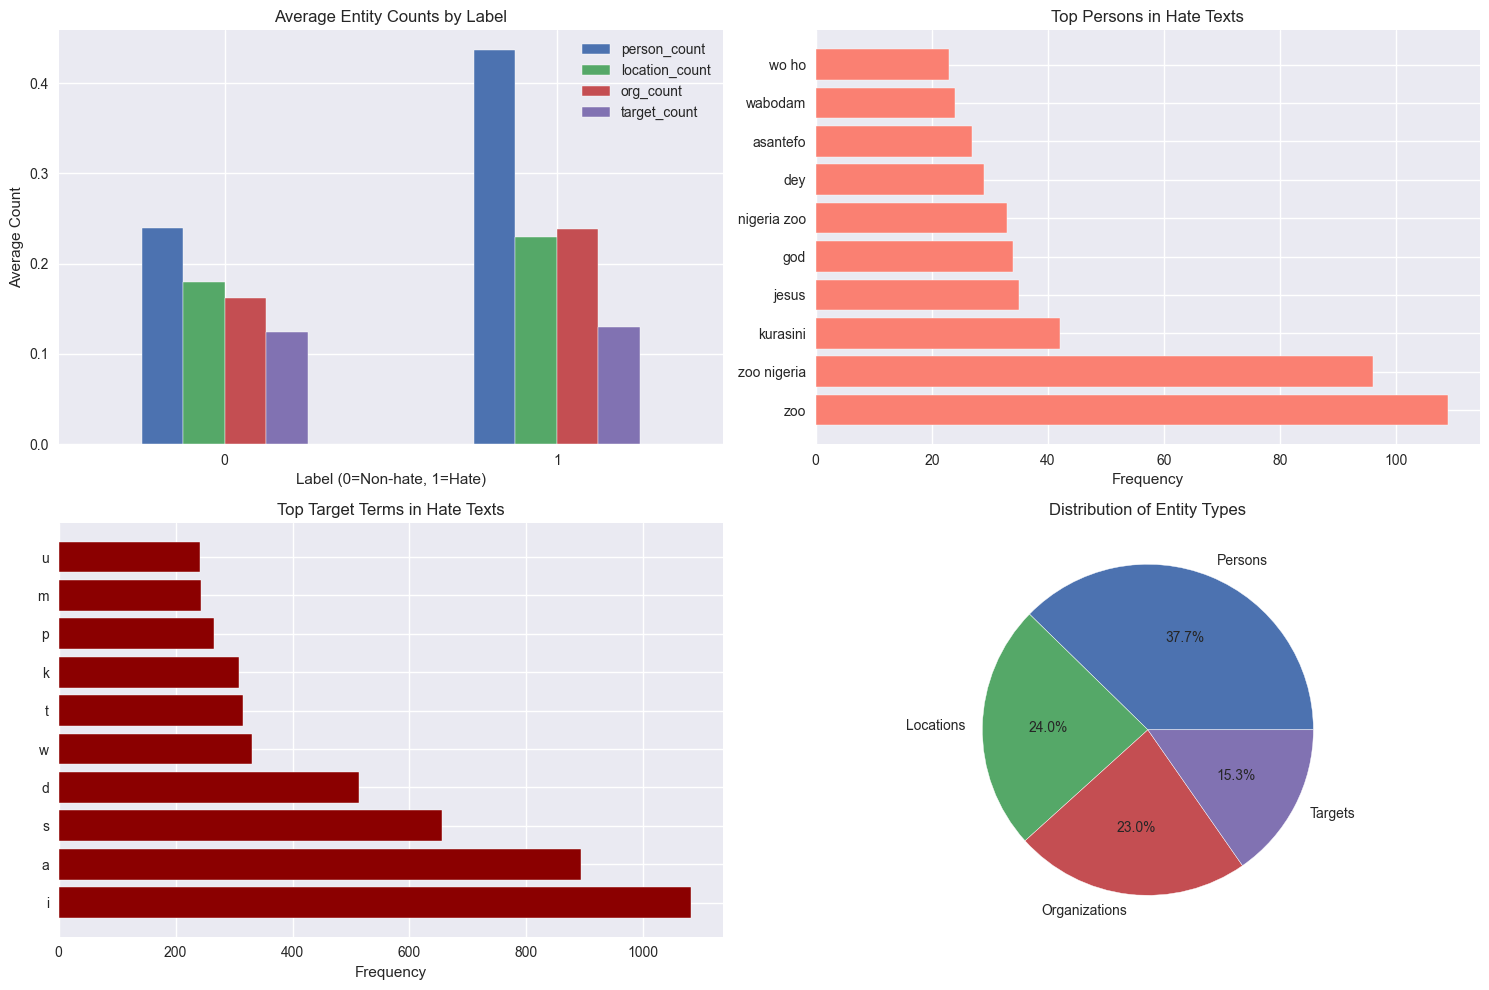

In [17]:
# 9. Named Entity Recognition and Target Analysis

def extract_entities(text):
    """Extract named entities using spaCy"""
    if pd.isna(text):
        return [], [], []

    try:
        doc = nlp(str(text))
        persons = [ent.text.lower()
                   for ent in doc.ents if ent.label_ == "PERSON"]
        locations = [ent.text.lower()
                     for ent in doc.ents if ent.label_ in ["GPE", "LOC"]]
        orgs = [ent.text.lower() for ent in doc.ents if ent.label_ == "ORG"]
        return persons, locations, orgs
    except:
        return [], [], []


def flag_pidgin_targets(text):
    """Flag common Pidgin target terms"""
    if pd.isna(text):
        return []

    text = str(text).lower()

    # Common target terms in Pidgin/Ghanaian context
    target_terms = {
        'ethnic_slurs': ['obruni', 'kwasia', 'gyimii', 'foolish'],
        'gender_slurs': ['ashawo', 'prostitute', 'slut'],
        'religious': ['infidel', 'pagan', 'heathen'],
        'general_insults': ['stupid', 'idiot', 'mad', 'crazy', 'senseless']
    }

    found_targets = []
    for category, terms in target_terms.items():
        for term in terms:
            if term in text:
                found_targets.append((category, term))

    return found_targets


print("Extracting named entities...")
entities = df['text'].apply(extract_entities)
df['persons'] = [x[0] for x in entities]
df['locations'] = [x[1] for x in entities]
df['organizations'] = [x[2] for x in entities]

print("Flagging Pidgin targets...")
df['pidgin_targets'] = df['text'].apply(flag_pidgin_targets)

# Entity counts
df['person_count'] = df['persons'].apply(len)
df['location_count'] = df['locations'].apply(len)
df['org_count'] = df['organizations'].apply(len)
df['target_count'] = df['pidgin_targets'].apply(len)

# Entity statistics by label
entity_stats = df.groupby(
    'label')[['person_count', 'location_count', 'org_count', 'target_count']].mean()
print("Entity Statistics by Label:")
print(entity_stats)

# Most common entities by label


def get_top_entities(entity_lists, top_k=10):
    all_entities = [entity for entities in entity_lists for entity in entities]
    return Counter(all_entities).most_common(top_k)


# Top entities by class
hate_persons = get_top_entities(df[df['label'] == 1]['persons'])
nonhate_persons = get_top_entities(df[df['label'] == 0]['persons'])

hate_targets = get_top_entities([target for targets in df[df['label'] == 1]['pidgin_targets']
                                for category, target in targets])
nonhate_targets = get_top_entities([target for targets in df[df['label'] == 0]['pidgin_targets']
                                   for category, target in targets])

print(f"\nTop persons mentioned in HATE texts:")
for entity, count in hate_persons:
    print(f"{entity}: {count}")

print(f"\nTop persons mentioned in NON-HATE texts:")
for entity, count in nonhate_persons:
    print(f"{entity}: {count}")

print(f"\nTop target terms in HATE texts:")
for target, count in hate_targets:
    print(f"{target}: {count}")

print(f"\nTop target terms in NON-HATE texts:")
for target, count in nonhate_targets:
    print(f"{target}: {count}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Entity counts by label
entity_stats.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Average Entity Counts by Label')
axes[0, 0].set_xlabel('Label (0=Non-hate, 1=Hate)')
axes[0, 0].set_ylabel('Average Count')
axes[0, 0].tick_params(axis='x', rotation=0)

# Top persons in hate texts
if hate_persons:
    persons, counts = zip(*hate_persons[:10])
    axes[0, 1].barh(range(len(persons)), counts, color='salmon')
    axes[0, 1].set_yticks(range(len(persons)))
    axes[0, 1].set_yticklabels(persons)
    axes[0, 1].set_title('Top Persons in Hate Texts')
    axes[0, 1].set_xlabel('Frequency')

# Top target terms in hate texts
if hate_targets:
    targets, counts = zip(*hate_targets[:10])
    axes[1, 0].barh(range(len(targets)), counts, color='darkred')
    axes[1, 0].set_yticks(range(len(targets)))
    axes[1, 0].set_yticklabels(targets)
    axes[1, 0].set_title('Top Target Terms in Hate Texts')
    axes[1, 0].set_xlabel('Frequency')

# Entity distribution
entity_counts = [df['person_count'].sum(), df['location_count'].sum(),
                 df['org_count'].sum(), df['target_count'].sum()]
entity_labels = ['Persons', 'Locations', 'Organizations', 'Targets']

axes[1, 1].pie(entity_counts, labels=entity_labels, autopct='%1.1f%%')
axes[1, 1].set_title('Distribution of Entity Types')

plt.tight_layout()
plt.show()

Creating TF-IDF vectors...
TF-IDF matrix shape: (22307, 1000)
Applying PCA...
TF-IDF matrix shape: (22307, 1000)
Applying PCA...
PCA explained variance ratio: [0.01453799 0.0141665 ]
Applying t-SNE...
PCA explained variance ratio: [0.01453799 0.0141665 ]
Applying t-SNE...
Performing K-means clustering...
Performing K-means clustering...
Cluster Statistics:
         label        word_count code_mixing_score polarity
         count   mean       mean              mean     mean
cluster                                                    
0        15060  0.424     14.411             0.048   -0.003
1         3695  0.114     14.191             0.011    0.030
2         3552  0.357     16.693             0.011   -0.107
Cluster Statistics:
         label        word_count code_mixing_score polarity
         count   mean       mean              mean     mean
cluster                                                    
0        15060  0.424     14.411             0.048   -0.003
1         3695  0.114

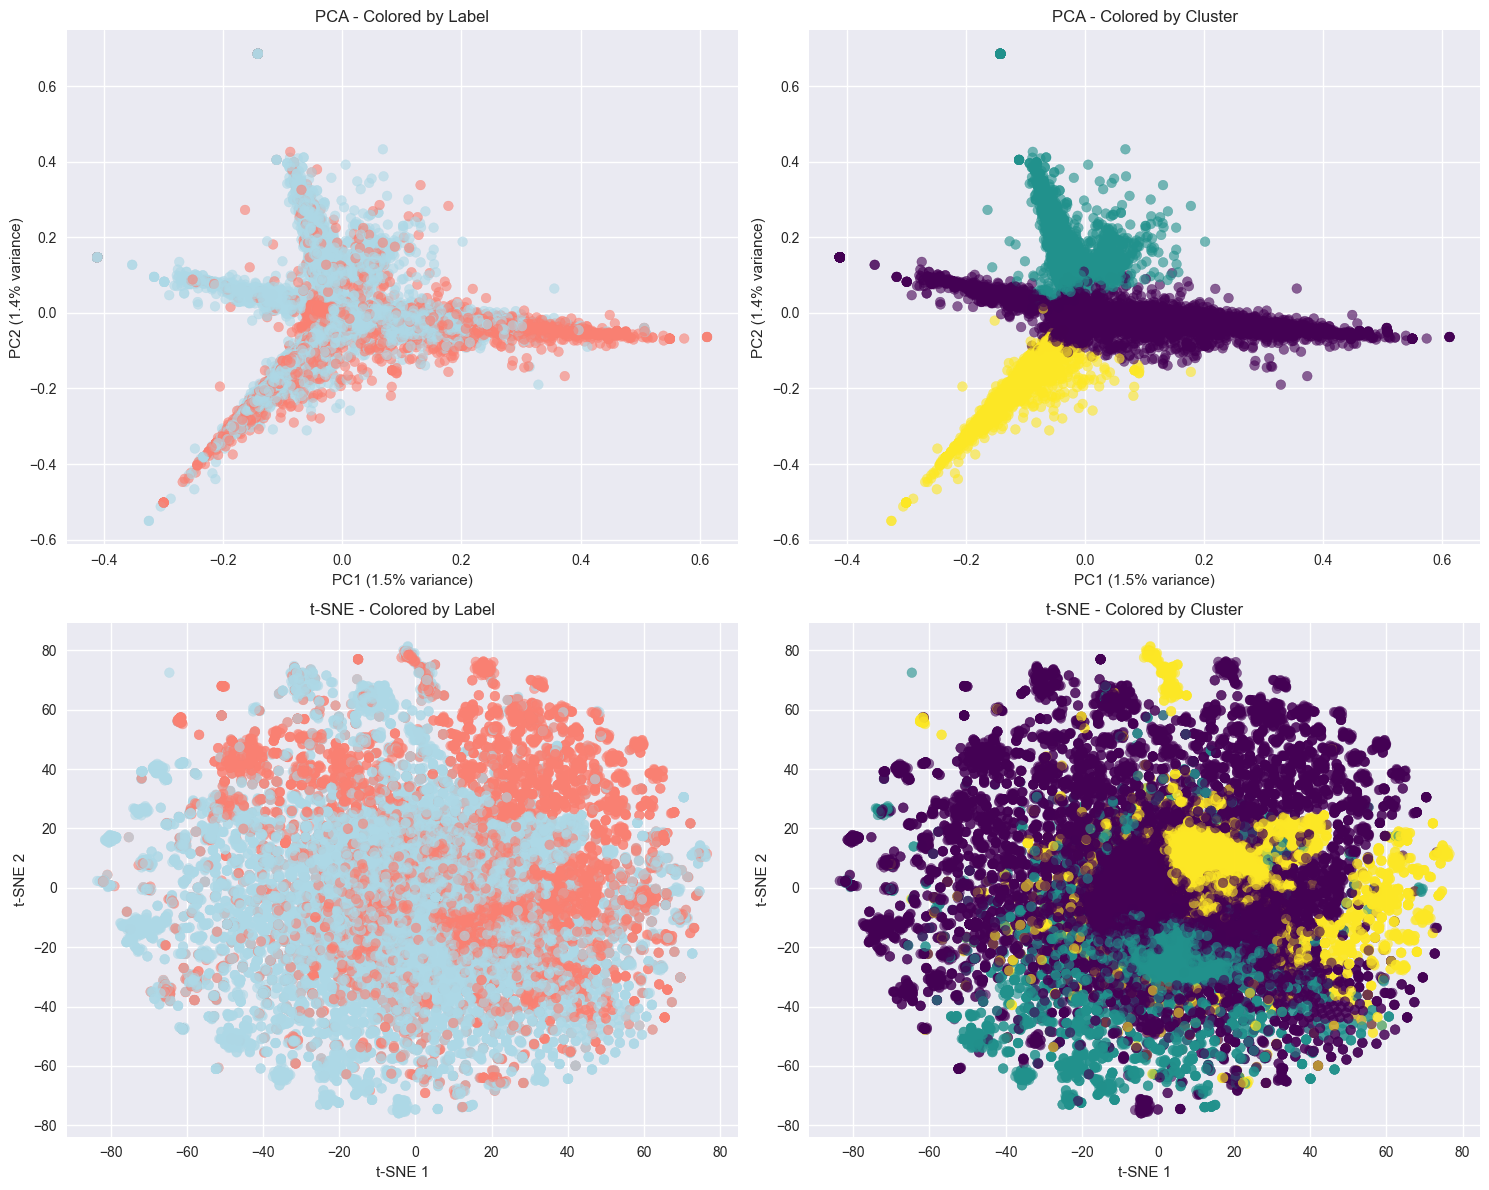

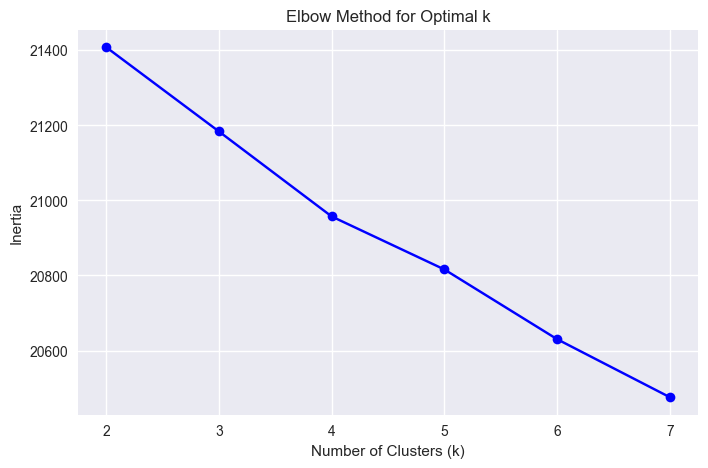

In [18]:
# 10. Dimensionality Reduction and Clustering

# Prepare texts for vectorization
texts_clean = df['text'].fillna('').astype(str).tolist()

# TF-IDF Vectorization
print("Creating TF-IDF vectors...")
vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    stop_words=None,  # Keep Pidgin words
    lowercase=True,
    min_df=2  # Ignore terms that appear in less than 2 documents
)

try:
    X_tfidf = vectorizer.fit_transform(texts_clean)
    feature_names = vectorizer.get_feature_names_out()

    print(f"TF-IDF matrix shape: {X_tfidf.shape}")

    # Convert to dense for processing
    X_dense = X_tfidf.toarray()

    # PCA
    print("Applying PCA...")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_dense)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

    # t-SNE
    print("Applying t-SNE...")
    tsne = TSNE(n_components=2, random_state=42,
                perplexity=min(30, len(df)//4))
    X_tsne = tsne.fit_transform(X_dense)

    # K-means clustering
    print("Performing K-means clustering...")

    # Elbow method for optimal k
    inertias = []
    k_range = range(2, min(8, len(df)//10))

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_dense)
        inertias.append(kmeans.inertia_)

    # Choose k=3 for interpretability
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_dense)

    # Add results to dataframe
    df['pca_1'] = X_pca[:, 0]
    df['pca_2'] = X_pca[:, 1]
    df['tsne_1'] = X_tsne[:, 0]
    df['tsne_2'] = X_tsne[:, 1]
    df['cluster'] = clusters

    # Cluster analysis
    cluster_stats = df.groupby('cluster').agg({
        'label': ['count', 'mean'],
        'word_count': 'mean',
        'code_mixing_score': 'mean',
        'polarity': 'mean'
    }).round(3)

    print("Cluster Statistics:")
    print(cluster_stats)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # PCA plot colored by label
    colors_label = ['lightblue' if x == 0 else 'salmon' for x in df['label']]
    axes[0, 0].scatter(df['pca_1'], df['pca_2'], c=colors_label, alpha=0.6)
    axes[0, 0].set_title('PCA - Colored by Label')
    axes[0, 0].set_xlabel(
        f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0, 0].set_ylabel(
        f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

    # PCA plot colored by cluster
    axes[0, 1].scatter(df['pca_1'], df['pca_2'],
                       c=df['cluster'], cmap='viridis', alpha=0.6)
    axes[0, 1].set_title('PCA - Colored by Cluster')
    axes[0, 1].set_xlabel(
        f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    axes[0, 1].set_ylabel(
        f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')

    # t-SNE plot colored by label
    axes[1, 0].scatter(df['tsne_1'], df['tsne_2'], c=colors_label, alpha=0.6)
    axes[1, 0].set_title('t-SNE - Colored by Label')
    axes[1, 0].set_xlabel('t-SNE 1')
    axes[1, 0].set_ylabel('t-SNE 2')

    # t-SNE plot colored by cluster
    axes[1, 1].scatter(df['tsne_1'], df['tsne_2'],
                       c=df['cluster'], cmap='viridis', alpha=0.6)
    axes[1, 1].set_title('t-SNE - Colored by Cluster')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')

    plt.tight_layout()
    plt.show()

    # Elbow plot
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Dimensionality reduction failed: {e}")
    df['cluster'] = 0  # Default cluster

Feature Correlations with Hate Label:
code_mixing_score: 0.3955
english_ratio: 0.3355
sent_count: 0.3119
avg_word_len: -0.2584
local_ratio: 0.2314
emoji_count: 0.2202
person_count: 0.1519
pidgin_ratio: 0.1503
subjectivity: -0.1420
org_count: 0.0804
char_count: -0.0518
location_count: 0.0464
word_count: 0.0299
polarity: 0.0132
target_count: 0.0061

Chi-square Tests:
Language vs Label: χ² = 1148.0834, p = 0.0000
Code-mixing vs Label: χ² = 2020.4524, p = 0.0000
Cluster vs Label: χ² = 1232.7883, p = 0.0000

Co-occurrence Analysis (Pidgin Slang + Hate Indicators):

'dey' co-occurs with:
  gyimii: 4 times
  kwasia: 3 times
  mad: 1 times
  foolish: 1 times

'abi' co-occurs with:
  kwasia: 2 times


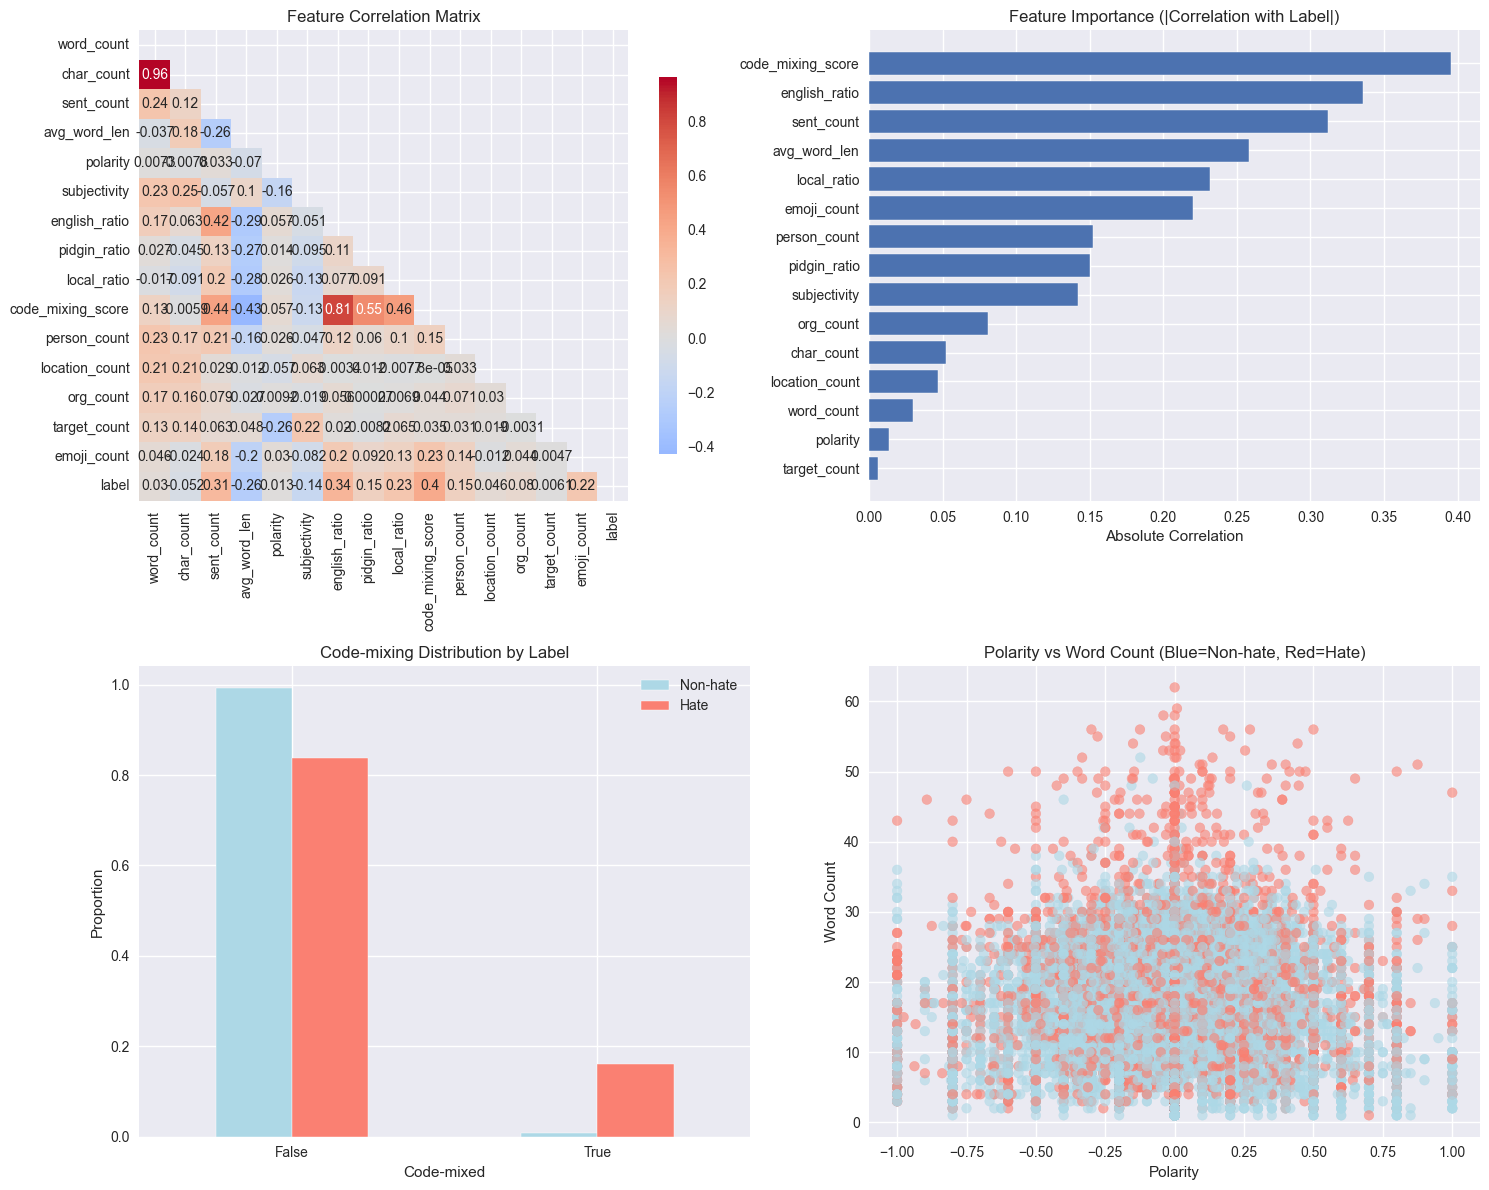

In [19]:
# 11. Correlation and Co-occurrence Analysis

# Select numerical features for correlation analysis
numerical_features = ['word_count', 'char_count', 'sent_count', 'avg_word_len',
                      'polarity', 'subjectivity', 'english_ratio', 'pidgin_ratio',
                      'local_ratio', 'code_mixing_score', 'person_count',
                      'location_count', 'org_count', 'target_count', 'emoji_count']

# Create correlation matrix
corr_features = numerical_features + ['label']
correlation_matrix = df[corr_features].corr()

print("Feature Correlations with Hate Label:")
label_corrs = correlation_matrix['label'].sort_values(key=abs, ascending=False)
for feature, corr in label_corrs.items():
    if feature != 'label':
        print(f"{feature}: {corr:.4f}")

# Chi-square test for categorical features


def chi_square_test(feature1, feature2):
    """Perform chi-square test"""
    try:
        contingency_table = pd.crosstab(feature1, feature2)
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        return chi2, p_value
    except:
        return 0, 1


# Test some categorical associations
categorical_tests = []

# Language vs Label
if 'detected_lang' in df.columns:
    chi2, p_val = chi_square_test(df['detected_lang'], df['label'])
    categorical_tests.append(('Language vs Label', chi2, p_val))

# Code-mixing vs Label
chi2, p_val = chi_square_test(df['is_code_mixed'], df['label'])
categorical_tests.append(('Code-mixing vs Label', chi2, p_val))

# Cluster vs Label
if 'cluster' in df.columns:
    chi2, p_val = chi_square_test(df['cluster'], df['label'])
    categorical_tests.append(('Cluster vs Label', chi2, p_val))

print(f"\nChi-square Tests:")
for test_name, chi2, p_val in categorical_tests:
    print(f"{test_name}: χ² = {chi2:.4f}, p = {p_val:.4f}")

# Co-occurrence analysis


def analyze_cooccurrence(texts, target_words, context_words, window_size=5):
    """Analyze co-occurrence of target words with context words"""
    cooccurrences = {}

    for text in texts:
        if pd.isna(text):
            continue

        words = str(text).lower().split()

        for i, word in enumerate(words):
            if word in target_words:
                # Look in window around target word
                start = max(0, i - window_size)
                end = min(len(words), i + window_size + 1)

                context = words[start:end]

                for context_word in context:
                    if context_word in context_words and context_word != word:
                        if word not in cooccurrences:
                            cooccurrences[word] = Counter()
                        cooccurrences[word][context_word] += 1

    return cooccurrences


# Define target and context words for Pidgin
pidgin_slang = ['chale', 'wahala', 'abeg', 'dey', 'wetin', 'abi', 'pikin']
hate_indicators = ['stupid', 'foolish', 'mad',
                   'crazy', 'idiot', 'kwasia', 'gyimii']

# Analyze co-occurrence in hate texts
hate_texts = df[df['label'] == 1]['text'].tolist()
cooccurrence_results = analyze_cooccurrence(
    hate_texts, pidgin_slang, hate_indicators)

print(f"\nCo-occurrence Analysis (Pidgin Slang + Hate Indicators):")
for slang_word, co_counts in cooccurrence_results.items():
    if co_counts:
        print(f"\n'{slang_word}' co-occurs with:")
        for hate_word, count in co_counts.most_common(5):
            print(f"  {hate_word}: {count} times")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Correlation heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
            center=0, ax=axes[0, 0], cbar_kws={'shrink': 0.8})
axes[0, 0].set_title('Feature Correlation Matrix')

# Feature importance (correlation with label)
label_corrs_abs = label_corrs.drop('label').abs().sort_values(ascending=True)
axes[0, 1].barh(range(len(label_corrs_abs)), label_corrs_abs.values)
axes[0, 1].set_yticks(range(len(label_corrs_abs)))
axes[0, 1].set_yticklabels(label_corrs_abs.index)
axes[0, 1].set_title('Feature Importance (|Correlation with Label|)')
axes[0, 1].set_xlabel('Absolute Correlation')

# Contingency table for code-mixing vs label
contingency_codemix = pd.crosstab(
    df['is_code_mixed'], df['label'], normalize='columns')
contingency_codemix.plot(kind='bar', ax=axes[1, 0], color=[
                         'lightblue', 'salmon'])
axes[1, 0].set_title('Code-mixing Distribution by Label')
axes[1, 0].set_xlabel('Code-mixed')
axes[1, 0].set_ylabel('Proportion')
axes[1, 0].legend(['Non-hate', 'Hate'])
axes[1, 0].tick_params(axis='x', rotation=0)

# Feature scatter: polarity vs word count
colors = ['lightblue' if x == 0 else 'salmon' for x in df['label']]
axes[1, 1].scatter(df['polarity'], df['word_count'], c=colors, alpha=0.6)
axes[1, 1].set_xlabel('Polarity')
axes[1, 1].set_ylabel('Word Count')
axes[1, 1].set_title('Polarity vs Word Count (Blue=Non-hate, Red=Hate)')

plt.tight_layout()
plt.show()


Subgroup Analysis:
short_text:
  Size: 11718 (52.5%)
  Hate rate: 0.370

long_text:
  Size: 10589 (47.5%)
  Hate rate: 0.353

code_mixed:
  Size: 1428 (6.4%)
  Hate rate: 0.915

pure_pidgin:
  Size: 20879 (93.6%)
  Hate rate: 0.324

emoji_heavy:
  Size: 913 (4.1%)
  Hate rate: 0.955

no_emoji:
  Size: 21394 (95.9%)
  Hate rate: 0.337

negative_sentiment:
  Size: 5696 (25.5%)
  Hate rate: 0.301

positive_sentiment:
  Size: 5209 (23.4%)
  Hate rate: 0.319

neutral_sentiment:
  Size: 11402 (51.1%)
  Hate rate: 0.412

mentions_entities:
  Size: 10278 (46.1%)
  Hate rate: 0.438

no_entities:
  Size: 12029 (53.9%)
  Hate rate: 0.297

has_targets:
  Size: 2618 (11.7%)
  Hate rate: 0.371

no_targets:
  Size: 19689 (88.3%)
  Hate rate: 0.361

Training Baseline Model for Error Analysis...
Overall F1 Score: 0.530

Performance by Subgroup:
short_text:
  F1 Score: 0.508
  Accuracy: 0.740
  Size: 11718

long_text:
  F1 Score: 0.557
  Accuracy: 0.775
  Size: 10589

code_mixed:
  F1 Score: 0.956
  Acc

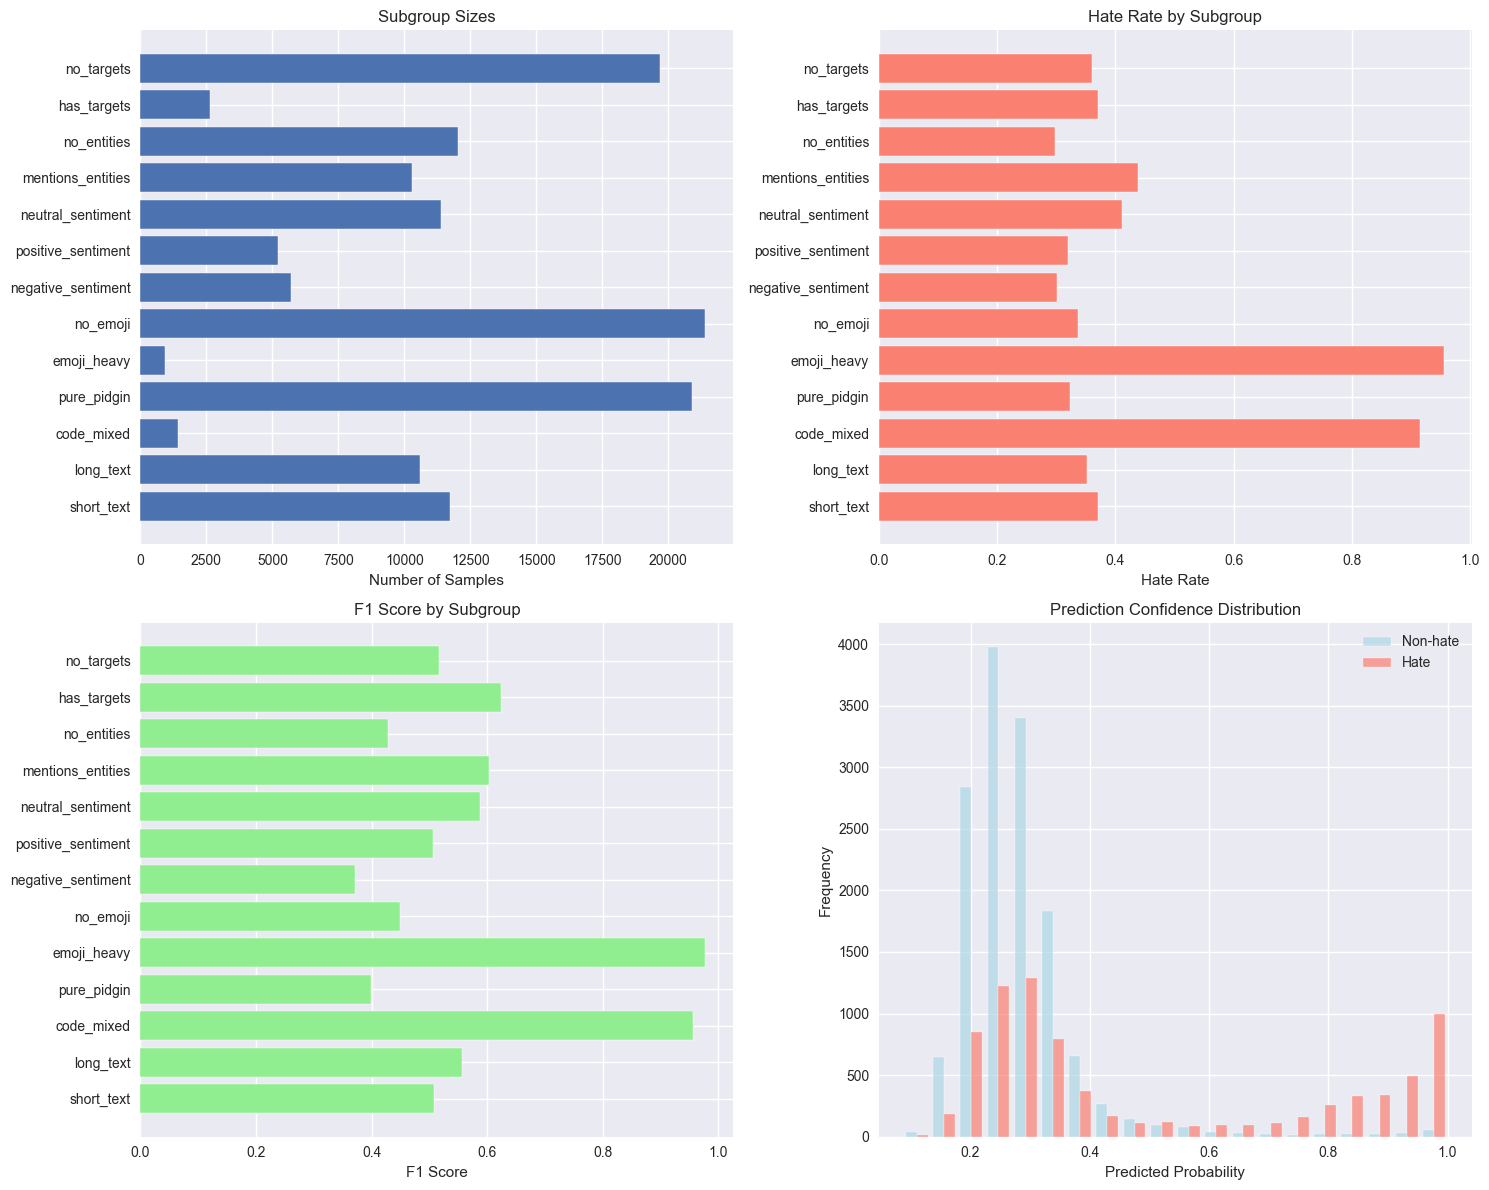


Feature Importance (Baseline Model):
             feature  importance
6  code_mixing_score    1.562992
1         char_count    0.759437
0         word_count    0.694225
9        emoji_count    0.623537
5       pidgin_ratio    0.515652
4      english_ratio    0.415861
3       subjectivity    0.179171
7       person_count    0.159843
2           polarity    0.087658
8       target_count    0.009407


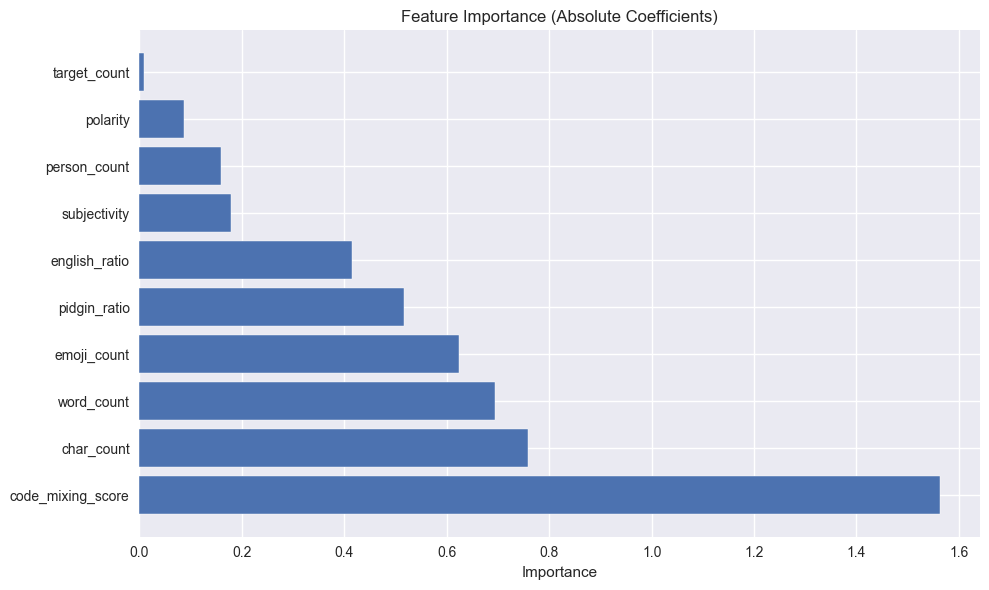

In [20]:
# 12. Subgroup and Error Slicing Analysis

# Define subgroups for analysis


def create_subgroups(df):
    """Create meaningful subgroups for analysis"""
    subgroups = {}

    # Length-based subgroups
    word_count_median = df['word_count'].median()
    subgroups['short_text'] = df['word_count'] <= word_count_median
    subgroups['long_text'] = df['word_count'] > word_count_median

    # Code-mixing subgroups
    subgroups['code_mixed'] = df['is_code_mixed']
    subgroups['pure_pidgin'] = ~df['is_code_mixed']

    # Emoji subgroups
    subgroups['emoji_heavy'] = df['emoji_count'] > 0
    subgroups['no_emoji'] = df['emoji_count'] == 0

    # Sentiment subgroups
    subgroups['negative_sentiment'] = df['polarity'] < -0.1
    subgroups['positive_sentiment'] = df['polarity'] > 0.1
    subgroups['neutral_sentiment'] = (
        df['polarity'] >= -0.1) & (df['polarity'] <= 0.1)

    # Entity subgroups
    subgroups['mentions_entities'] = (
        df['person_count'] + df['location_count'] + df['org_count']) > 0
    subgroups['no_entities'] = (
        df['person_count'] + df['location_count'] + df['org_count']) == 0

    # Target terms subgroups
    subgroups['has_targets'] = df['target_count'] > 0
    subgroups['no_targets'] = df['target_count'] == 0

    return subgroups


# Create subgroups
subgroups = create_subgroups(df)

# Analyze class distribution in subgroups
print("Subgroup Analysis:")
print("="*50)

subgroup_stats = {}
for subgroup_name, mask in subgroups.items():
    if mask.sum() > 0:  # Ensure subgroup is not empty
        subgroup_data = df[mask]
        hate_rate = subgroup_data['label'].mean()
        size = len(subgroup_data)

        subgroup_stats[subgroup_name] = {
            'size': size,
            'hate_rate': hate_rate,
            'size_pct': size / len(df) * 100
        }

        print(f"{subgroup_name}:")
        print(f"  Size: {size} ({size/len(df)*100:.1f}%)")
        print(f"  Hate rate: {hate_rate:.3f}")
        print()

# Simple baseline model for error analysis
print("Training Baseline Model for Error Analysis...")

# Prepare features for baseline model
feature_cols = ['word_count', 'char_count', 'polarity', 'subjectivity',
                'english_ratio', 'pidgin_ratio', 'code_mixing_score',
                'person_count', 'target_count', 'emoji_count']

X = df[feature_cols].fillna(0)
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train simple logistic regression
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Predict on full dataset for error analysis
X_scaled = scaler.transform(X)
y_pred = baseline_model.predict(X_scaled)
y_pred_proba = baseline_model.predict_proba(X_scaled)[:, 1]

# Add predictions to dataframe
df['pred_label'] = y_pred
df['pred_proba'] = y_pred_proba
df['is_correct'] = df['label'] == df['pred_label']

# Overall performance
overall_f1 = f1_score(y, y_pred)
print(f"Overall F1 Score: {overall_f1:.3f}")

# Performance by subgroup
print("\nPerformance by Subgroup:")
print("="*50)

subgroup_performance = {}
for subgroup_name, mask in subgroups.items():
    if mask.sum() > 10:  # Only analyze subgroups with sufficient data
        subgroup_y = y[mask]
        subgroup_pred = y_pred[mask]

        if len(np.unique(subgroup_y)) > 1:  # Ensure both classes present
            f1 = f1_score(subgroup_y, subgroup_pred)
            accuracy = (subgroup_y == subgroup_pred).mean()

            subgroup_performance[subgroup_name] = {
                'f1': f1,
                'accuracy': accuracy,
                'size': mask.sum()
            }

            print(f"{subgroup_name}:")
            print(f"  F1 Score: {f1:.3f}")
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  Size: {mask.sum()}")
            print()

# Error analysis
print("Error Analysis:")
print("="*30)

# False positives and false negatives
false_positives = df[(df['label'] == 0) & (df['pred_label'] == 1)]
false_negatives = df[(df['label'] == 1) & (df['pred_label'] == 0)]

print(f"False Positives: {len(false_positives)}")
print(f"False Negatives: {len(false_negatives)}")

# Most confident wrong predictions
confident_wrong = df[~df['is_correct'] & (
    (df['pred_proba'] > 0.8) | (df['pred_proba'] < 0.2))]
print(f"Confident Wrong Predictions: {len(confident_wrong)}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Subgroup sizes
subgroup_sizes = {name: stats['size']
                  for name, stats in subgroup_stats.items()}
axes[0, 0].barh(list(subgroup_sizes.keys()), list(subgroup_sizes.values()))
axes[0, 0].set_title('Subgroup Sizes')
axes[0, 0].set_xlabel('Number of Samples')

# Hate rates by subgroup
hate_rates = {name: stats['hate_rate']
              for name, stats in subgroup_stats.items()}
axes[0, 1].barh(list(hate_rates.keys()), list(
    hate_rates.values()), color='salmon')
axes[0, 1].set_title('Hate Rate by Subgroup')
axes[0, 1].set_xlabel('Hate Rate')

# F1 scores by subgroup
f1_scores = {name: perf['f1'] for name, perf in subgroup_performance.items()}
axes[1, 0].barh(list(f1_scores.keys()), list(
    f1_scores.values()), color='lightgreen')
axes[1, 0].set_title('F1 Score by Subgroup')
axes[1, 0].set_xlabel('F1 Score')

# Prediction confidence distribution
axes[1, 1].hist([df[df['label'] == 0]['pred_proba'], df[df['label'] == 1]['pred_proba']],
                bins=20, alpha=0.7, label=['Non-hate', 'Hate'], color=['lightblue', 'salmon'])
axes[1, 1].set_title('Prediction Confidence Distribution')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Feature importance from logistic regression
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': np.abs(baseline_model.coef_[0])
}).sort_values('importance', ascending=False)

print("\nFeature Importance (Baseline Model):")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.title('Feature Importance (Absolute Coefficients)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
